# Higgs Boson Machine Learning Project

## Tips for running the notebook

Please, do not run the entire notebook as some specific sections (and their subsequent cells) have very high running times. It is better to run cells one at a time. The sections that are highly time-consuming are the following:
- K-Neirest-Neighbors 
- Random Forest


The reader will be alerted again at the section level when it is a highly time-consuming cell.

To import the correct dataset, the user should browse its depository containing the training and test files (as given in the mail) in the next line. 

# Data importation

In [1]:
# Browse the correct depository to import the project dataset
%cd /Users/lauramisrachi/Documents/Master\ Maths\ appliqués\ UPMC/Apprentissage\ statistique/projet\ final\ machine\ learning/

/Users/lauramisrachi/Documents/Master Maths appliqués UPMC/Apprentissage statistique/projet final machine learning


In [2]:
# Import the required modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from itertools import compress
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Activation, Dense
import keras.backend as K
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Importing the kaggle project datasets
train_set = pd.read_csv("training.csv")
test_set = pd.read_csv("test.csv")

In [4]:
train_set.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


## Understanding the imported data
Some details on the dataset to get started:

* all variables are floating point, except PRI_jet_num which is integer (factor feature).
* variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
* variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by  the physicists of ATLAS
* it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables ==> this is the equivalent to the NA value.

* One should notice that the "Weight" feature is not present in the dataset meaning that it cannot be used for learning. We will try to understand later how it might be used for training. 

* 31 variables shared by the train and test set. 

# Exploratory Data Analysis

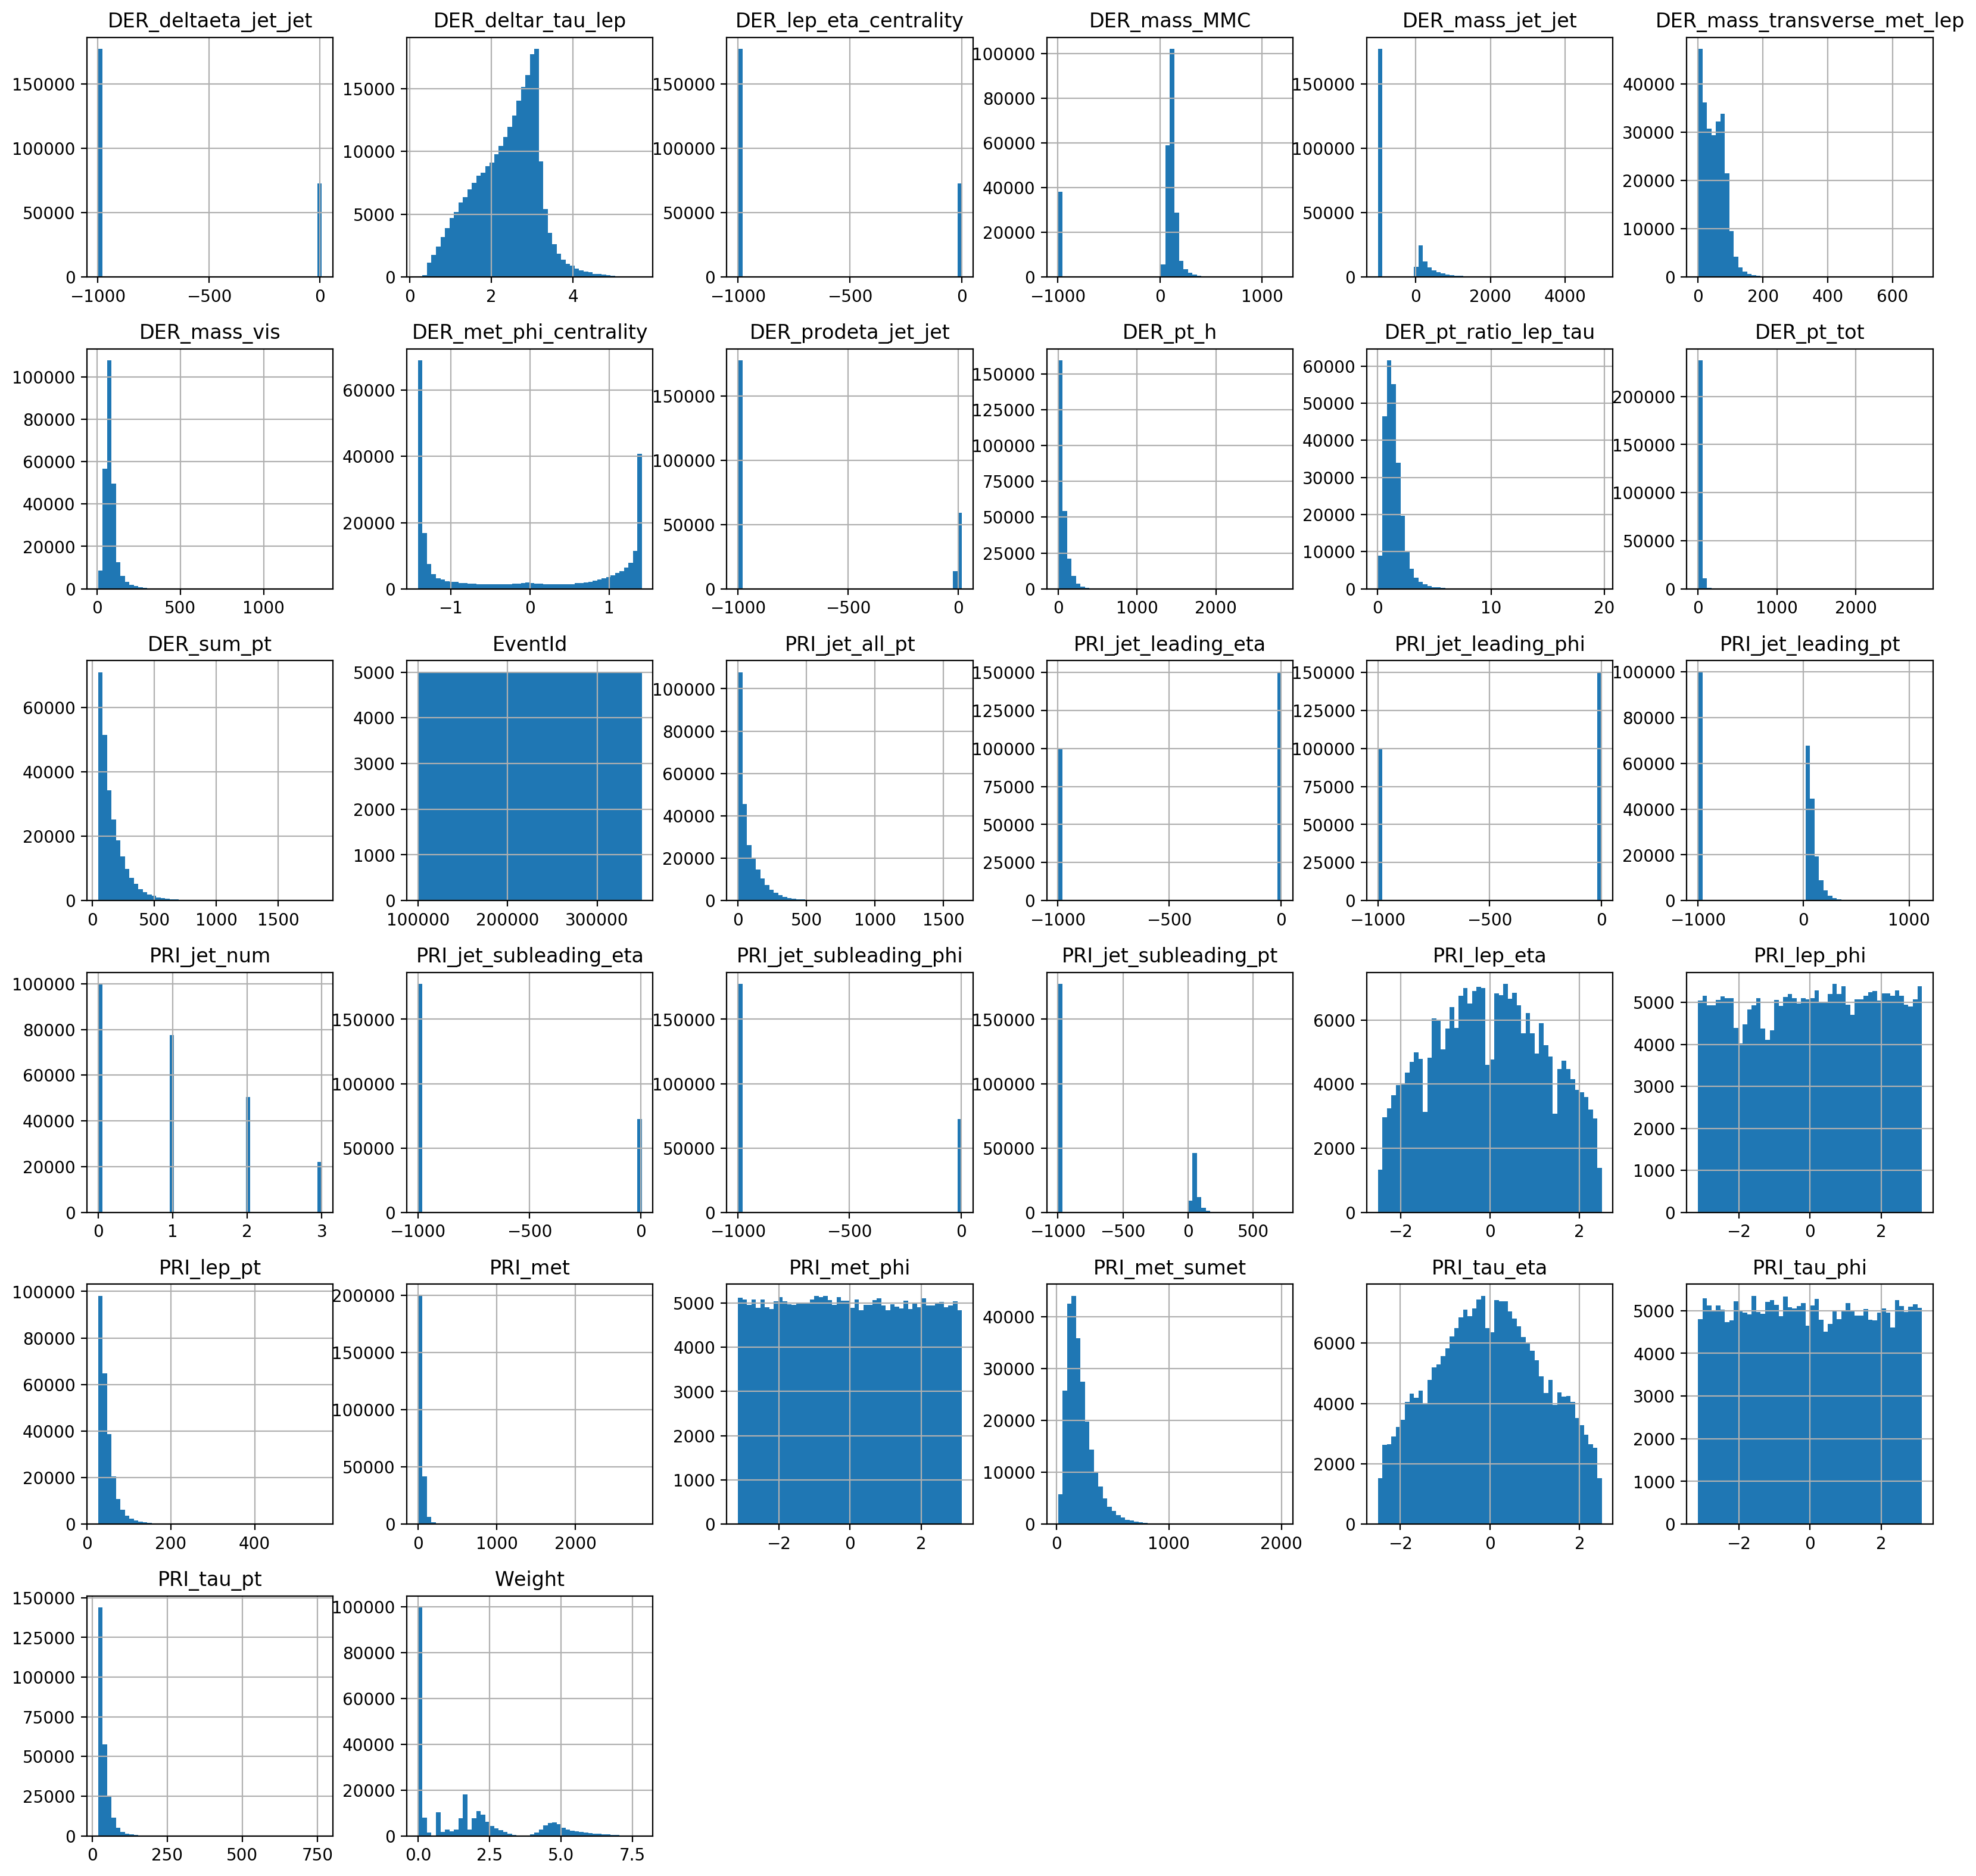

In [500]:
train_set.hist(bins=50, figsize = (20,20));

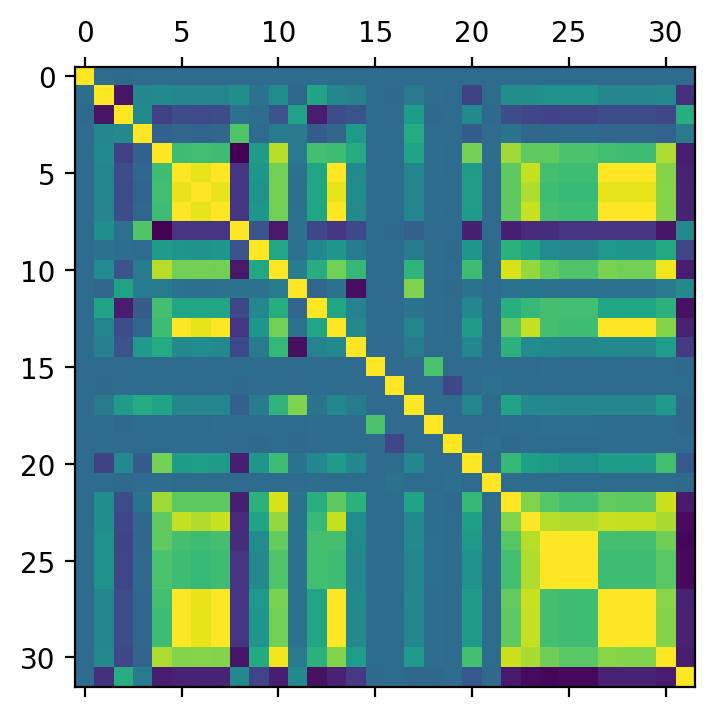

In [501]:
plt.matshow(train_set.corr()) ; 
ax2.legend(bbox_to_anchor=(1.05, 1), loc=4, borderaxespad=0.);

It looks like we have confirmation that -999 was used to refer to NA/missing values. We are going to recode it accordingly. 

## Handling missing values

In [5]:
def replace_999_Nan(X):
    X = X.replace(to_replace = -999, value = np.nan)
    return X

Text(0.5,1,'Percentage of missing values per feature')

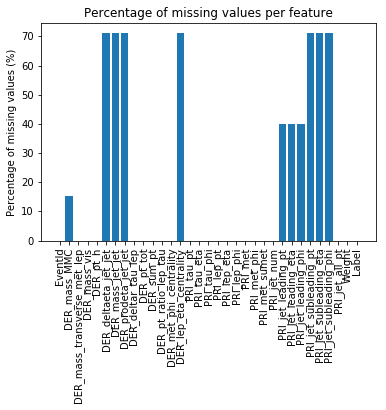

In [6]:
train_set = replace_999_Nan(train_set)
test_set = replace_999_Nan(test_set)
missing_values_info = pd.isnull(train_set).sum()/train_set.shape[0] * 100
x_ticks_labels = missing_values_info.index;
fig, ax = plt.subplots(1,1)
x = np.arange(len(missing_values_info.index));
y = missing_values_info.values;
ax.bar(x,y, width = 0.8)
# Set number of ticks for x-axis
ax.set_xticks(x);
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, rotation=90, fontsize=10);
plt.ylabel('Percentage of missing values (%)')
plt.title('Percentage of missing values per feature')

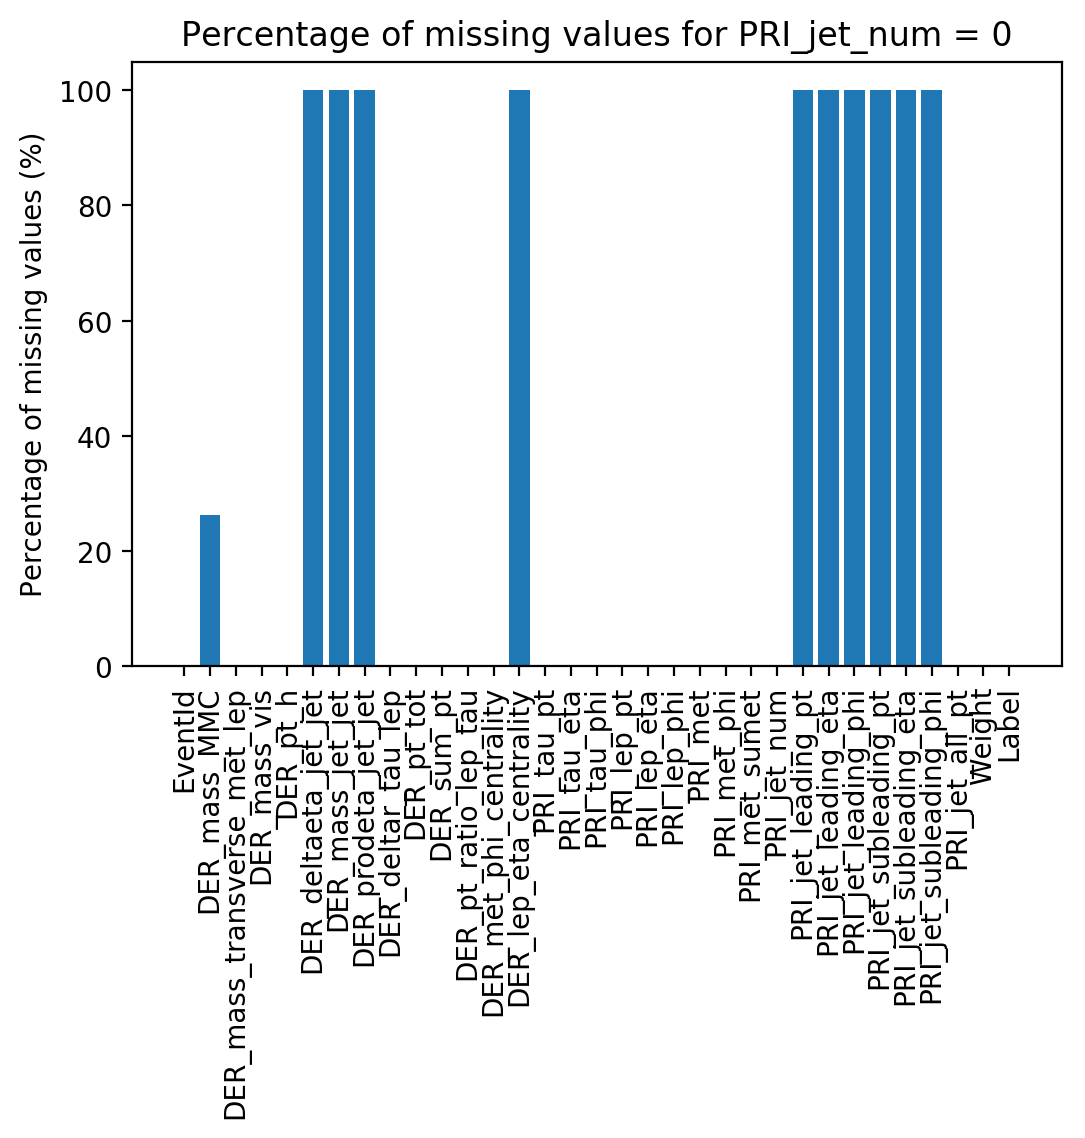

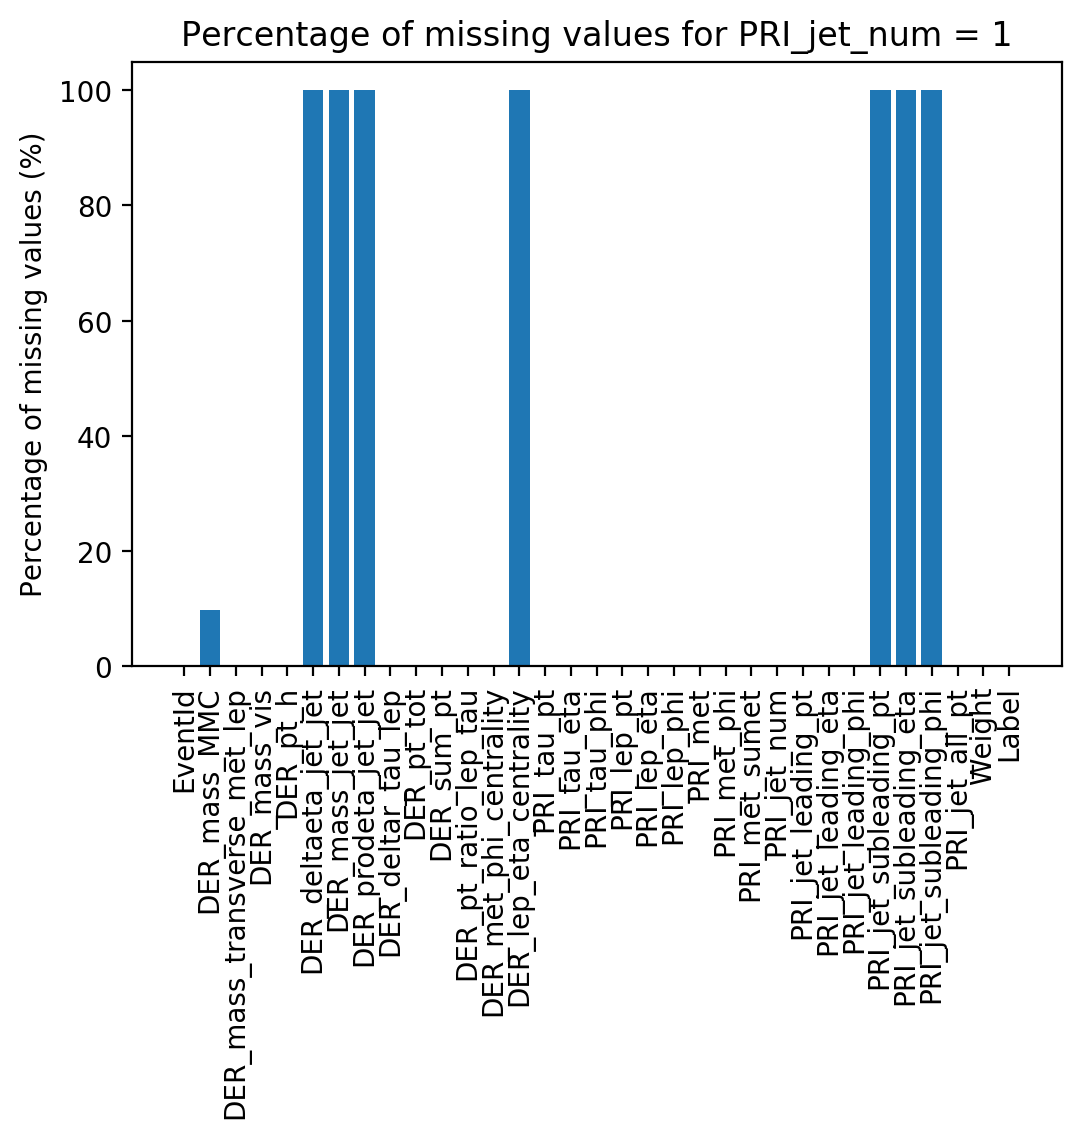

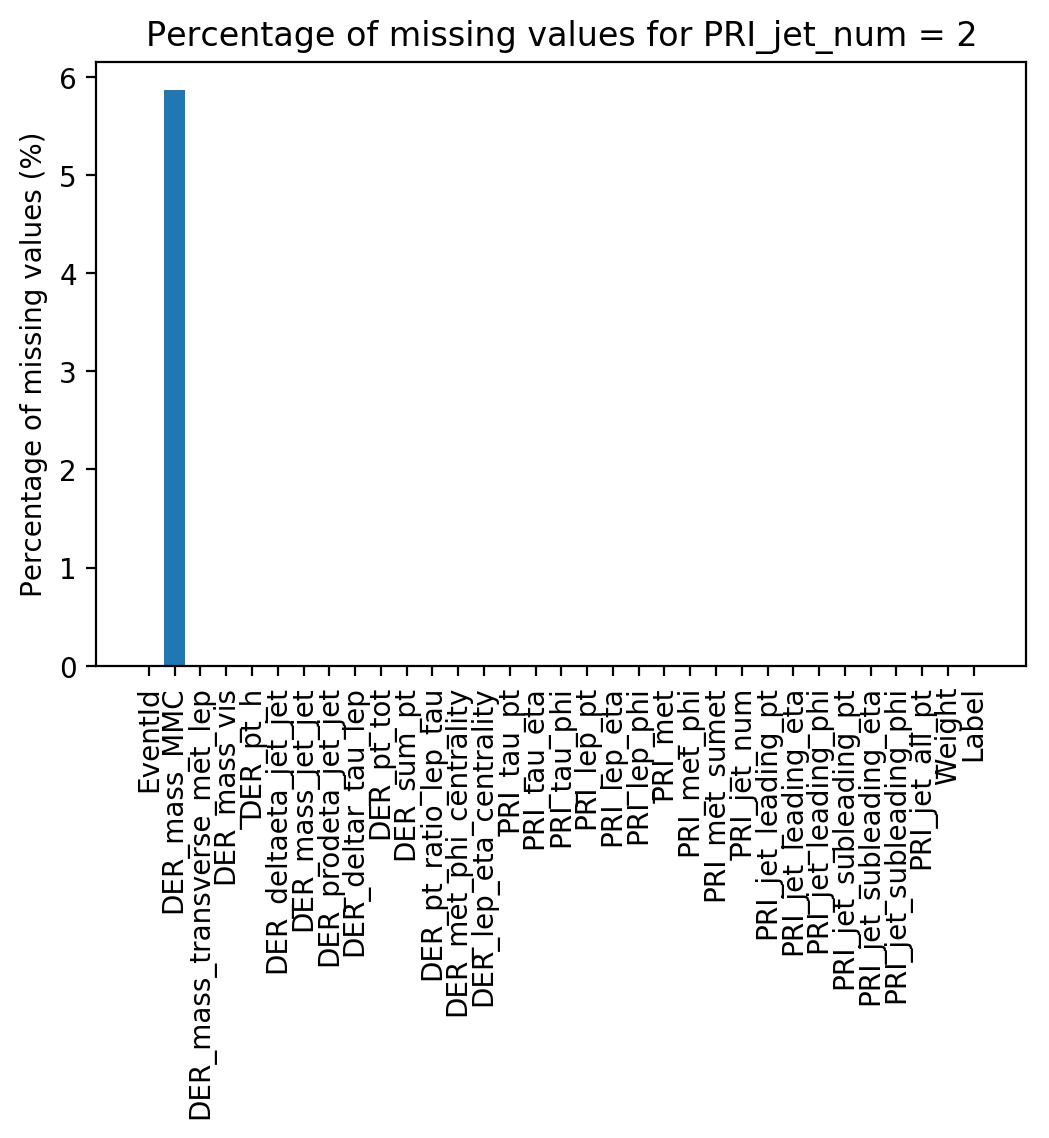

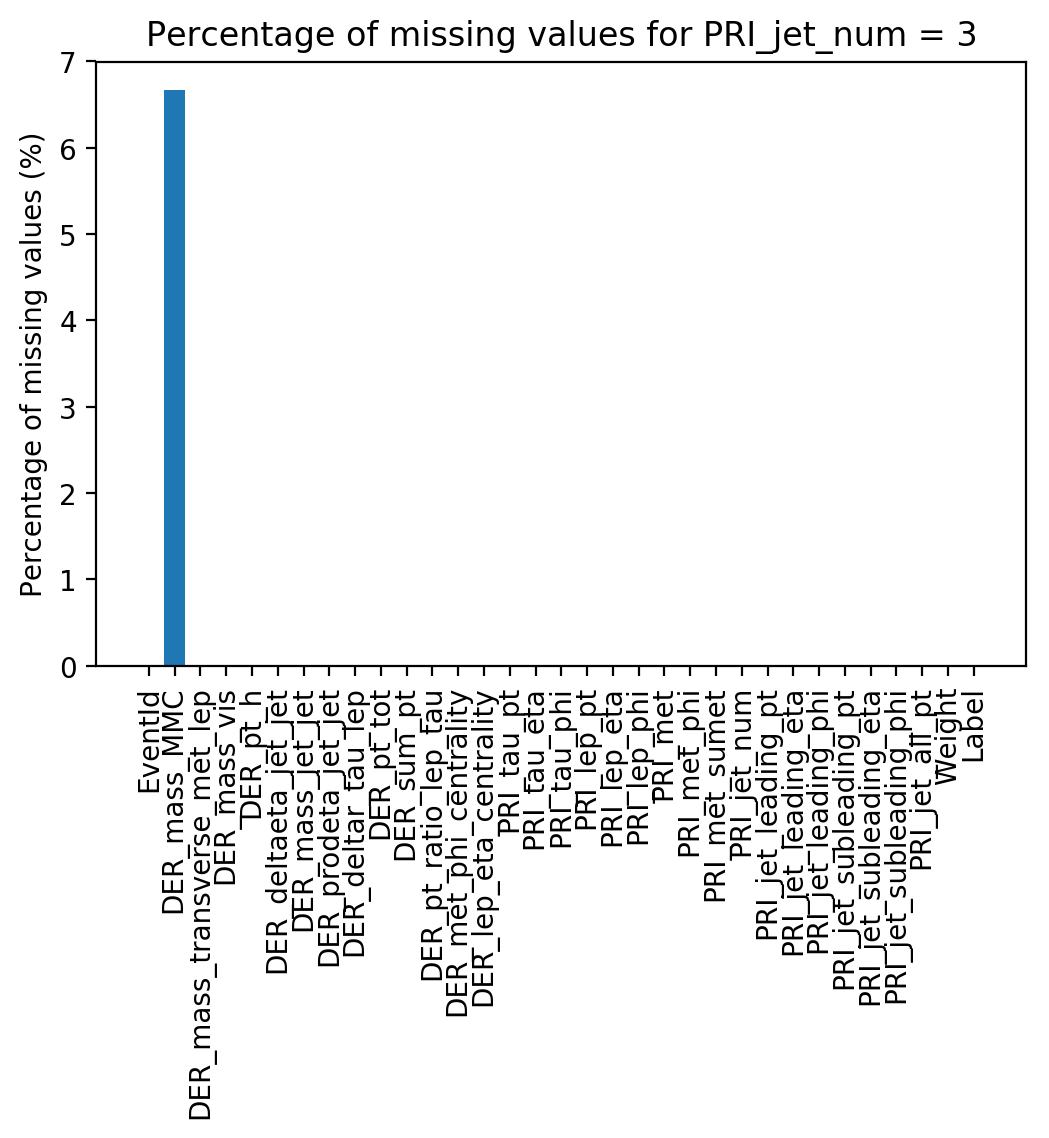

In [504]:
# Plotting the percentage of missing values for each value of the PRI_jet_num feature
for e in np.sort(train_set['PRI_jet_num'].unique()):
    titlelist = 'Percentage of missing values for PRI_jet_num = ' + str(e)
    train_set_e = train_set[train_set.PRI_jet_num == e]
    missing_values_info = pd.isnull(train_set_e).sum()/train_set_e.shape[0] * 100
    x_ticks_labels = missing_values_info.index;
    fig, ax = plt.subplots(1,1) ;
    x = np.arange(len(missing_values_info.index));
    y = missing_values_info.values;
    ax.bar(x,y, width = 0.8)
    # Set number of ticks for x-axis
    ax.set_xticks(x);
    # Set ticks labels for x-axis
    ax.set_xticklabels(x_ticks_labels, rotation=90, fontsize=10);
    ax.set_title(titlelist)
    plt.ylabel('Percentage of missing values (%)')

Following these observations, we understand that the missing values (which are not the consequences of bad/wrong measurements, but are more linked to the inherent structures of the measures) can be linked with the values of the integer PRI_jet_num feature. Indeed, we observe that, for most features with missing values, these are completely missing or not missing at all, based on the values of the PRI_jet_num feature. This is true, except for the DER_mass_MMC feature for which there is, for each given value of the PRI_jet_num feature a certain percentage (> 0, < 100) of missing values. In order to handle all the missing values, our idea is to subset our training set in 8 bins which correspond to all the combination for which we would not have any missing values, given that we got rid off the adequate features. The 8 bins come from the following configurations:

* 4 possibles values for the PRI_jet_num feature : 0,1,2,3
* 2 subsets : 1 where DER_mass_MMC is always missing, and the other where it is never missing. 

Subsequently, we train 8 different classifiers (with no missing values) and aggregate the data together at last. 

In [505]:
# Creating 8 bins for our 8 different classifiers (PRI_jet_num feature and DER_mass_MMC)
def creating_8_bins_missing_values(X):
    l = []
    X = replace_999_Nan(X)
    for e in np.sort(train_set['PRI_jet_num'].unique()):
        # We add the part of the dataset which only contains NaN values for DER_mass_MMC
        X_e_NaN = X[(X.PRI_jet_num == e) & (X.DER_mass_MMC.isnull())]
        # We add the part of the dataset which only contains not NaN values for DER_mass_MMC
        X_e_not_NaN = X[(X.PRI_jet_num == e) & (X.DER_mass_MMC.notnull())]
        # We get ridd off the features that are missing 100% of their values
        columns_to_save = X_e_NaN.columns[X_e_NaN.isnull().sum() == 0]
        X_e_NaN = X_e_NaN[columns_to_save] 
        columns_to_save = X_e_not_NaN.columns[X_e_not_NaN.isnull().sum() == 0]
        X_e_not_NaN = X_e_not_NaN[columns_to_save] 
        # We also get rid off the feature PRI_jet_num which is now unique for each training set
        X_e_NaN = X_e_NaN.drop(['PRI_jet_num'], axis = 1)
        X_e_not_NaN = X_e_not_NaN.drop(['PRI_jet_num'], axis = 1)
        # We append these to the final list
        l.append(X_e_NaN)
        l.append(X_e_not_NaN)
    return l

In [506]:
# Creating 4 bins for our 4 different classifiers (PRI_jet_num feature)
def creating_4_bins_missing_values(X):
    l = []
    X = replace_999_Nan(X)
    for e in np.sort(train_set['PRI_jet_num'].unique()):
        X_e = X[(X.PRI_jet_num == e)]
        columns_to_save = X_e.columns[X_e.isnull().sum() < X_e.shape[0]]
        X_e = X_e[columns_to_save] 
        # We also get rid off the feature PRI_jet_num which is now unique for each training set
        X_e = X_e.drop(['PRI_jet_num'], axis = 1)
        # Replacing missing values of feature DER_mass_MMC by mean value
        X_e['DER_mass_MMC'] = X_e['DER_mass_MMC'].replace(to_replace = np.nan, value = X_e['DER_mass_MMC'].mean())
        # We append these to the final list
        l.append(X_e)
    return l

In [17]:
# replacing NaN by mean values
def replacing_nan_by_mean(X):
    columns_with_nan = X.columns[X.isnull().sum() > 0]
    for i in columns_with_nan:   
        X[i] = X[i].replace(to_replace = np.nan, value = X[i].mean())
    return X

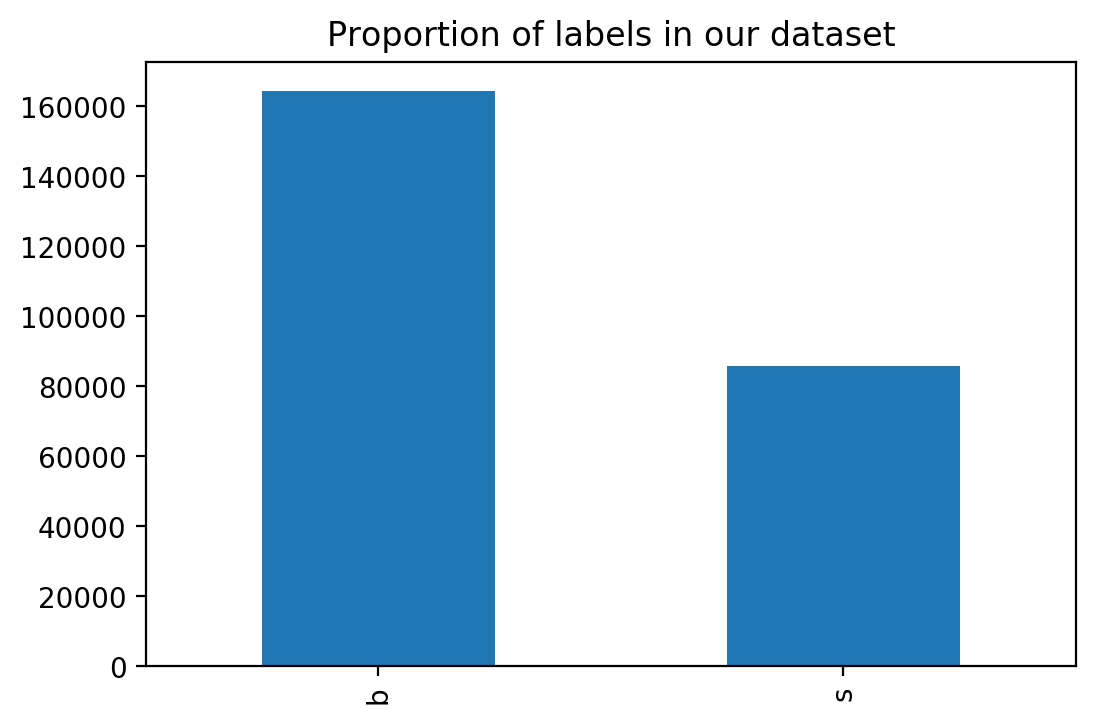

In [508]:
# Having a look at the proportion of b and s events in the training set:
train_set['Label'].value_counts().plot(kind = 'bar');
plt.title('Proportion of labels in our dataset')

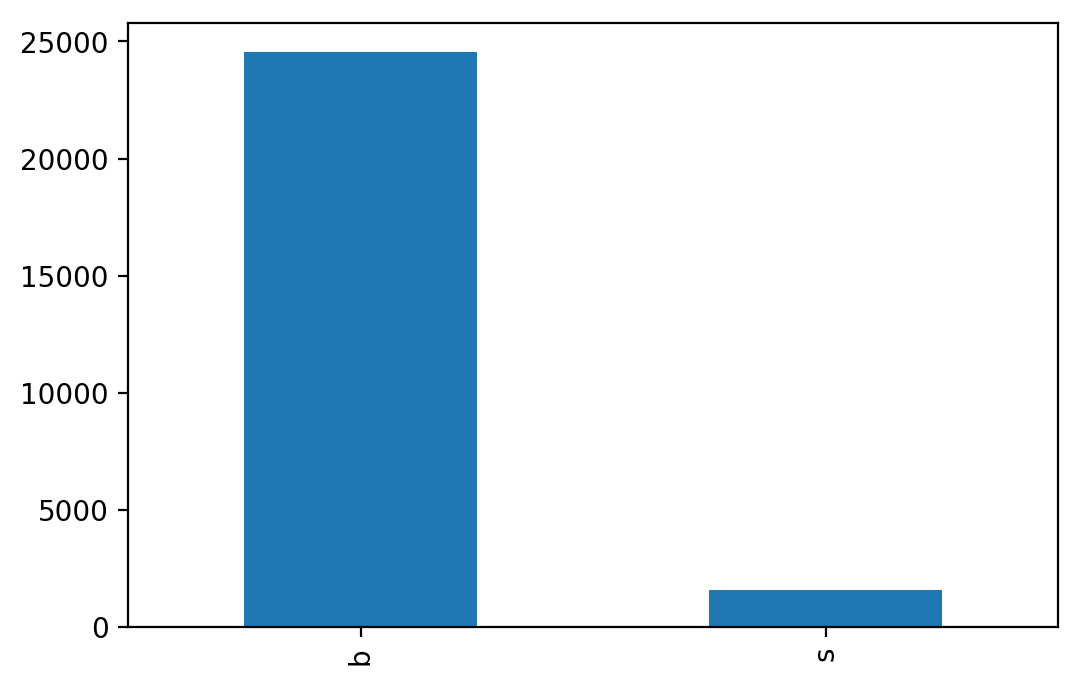

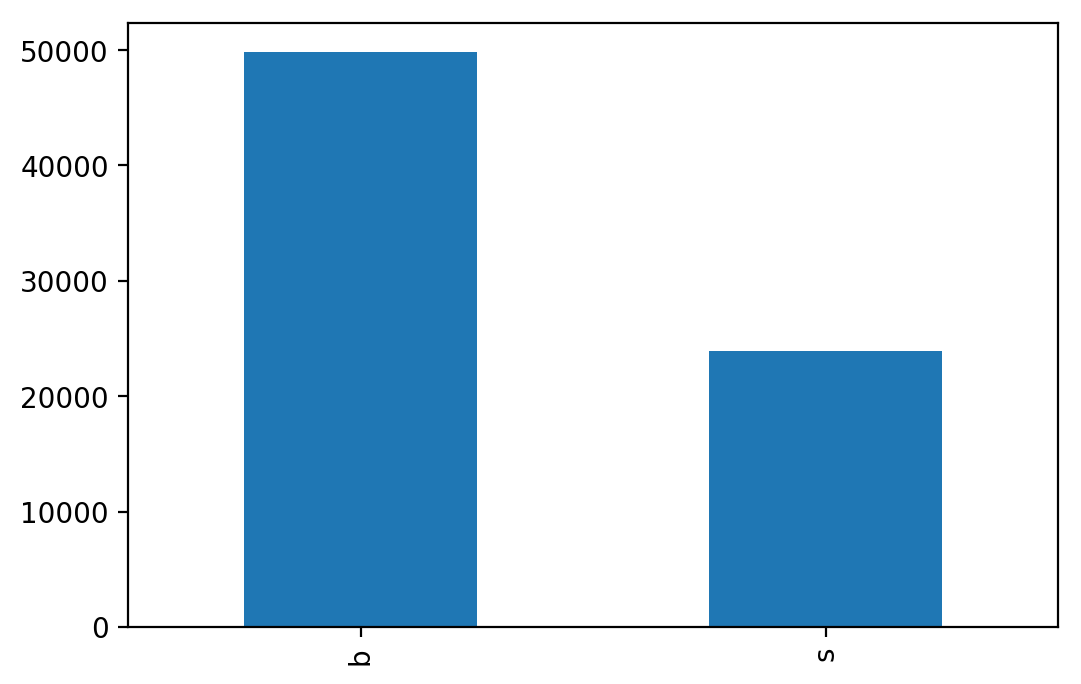

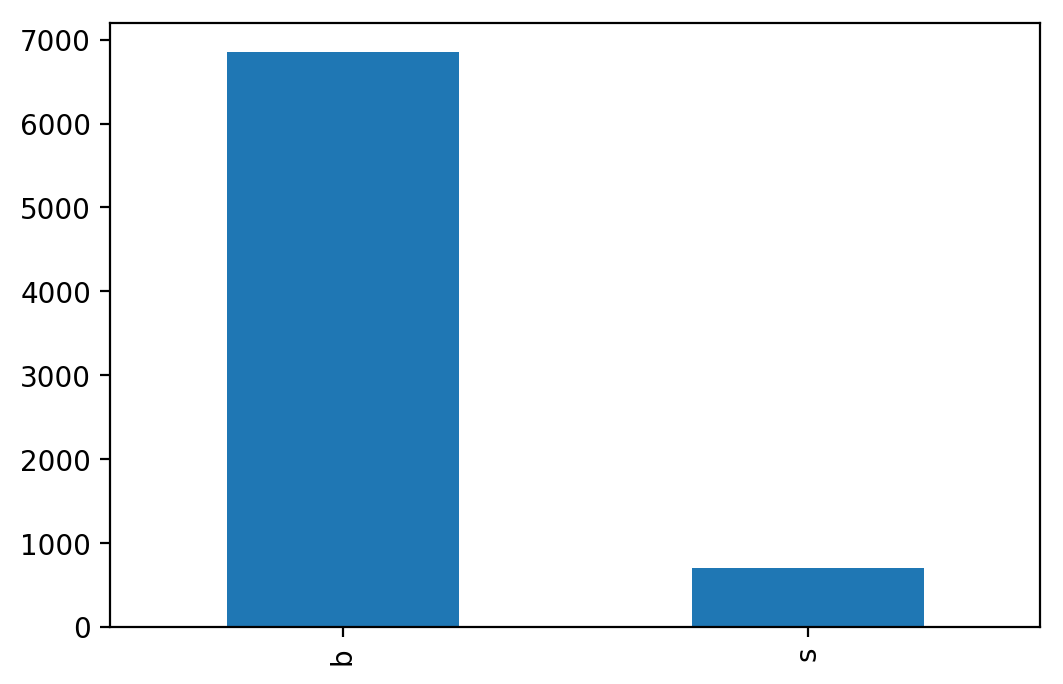

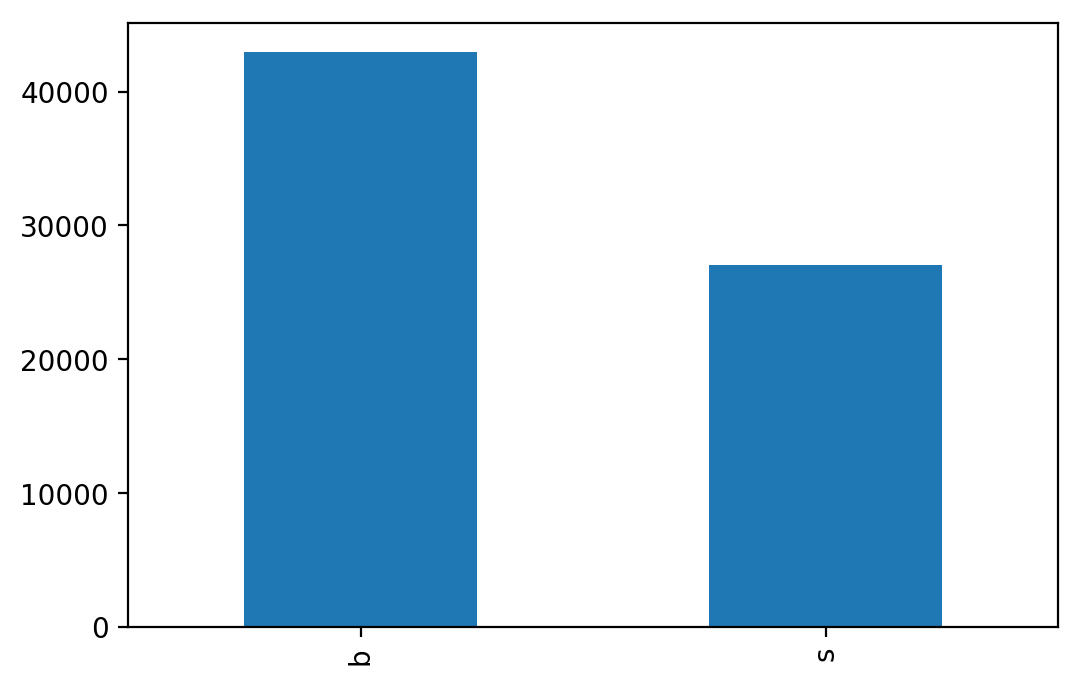

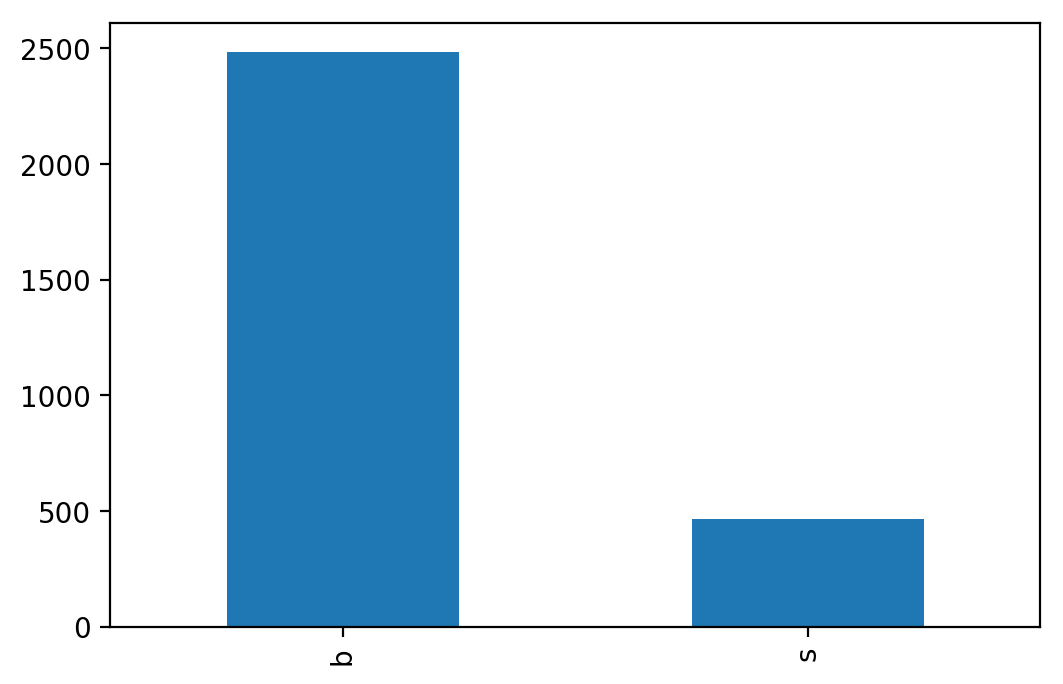

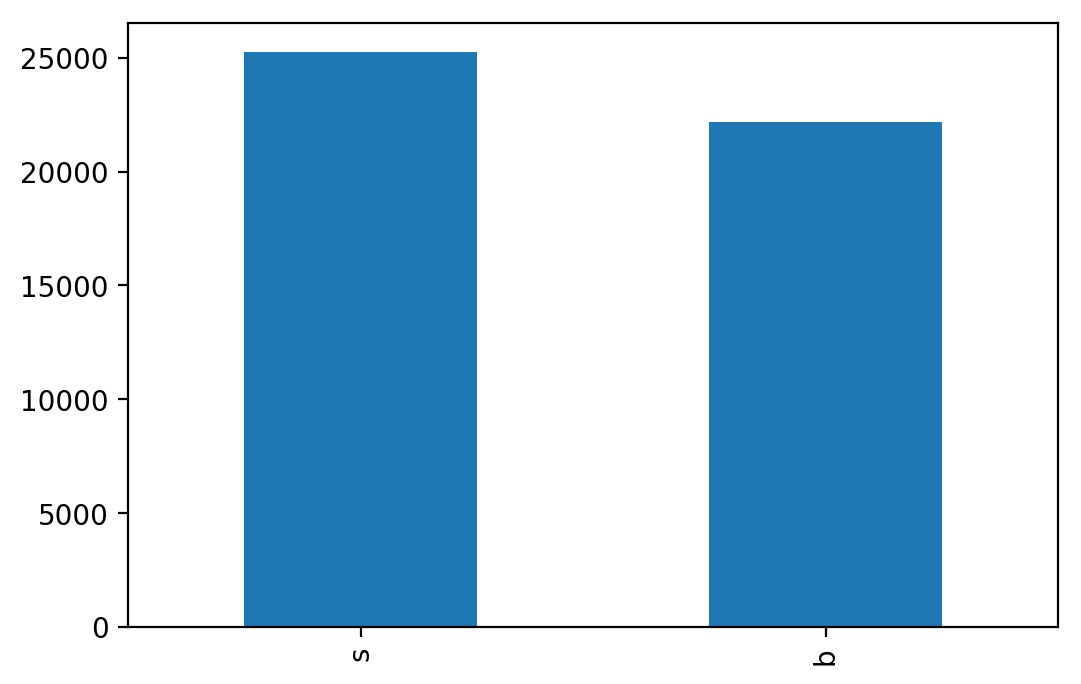

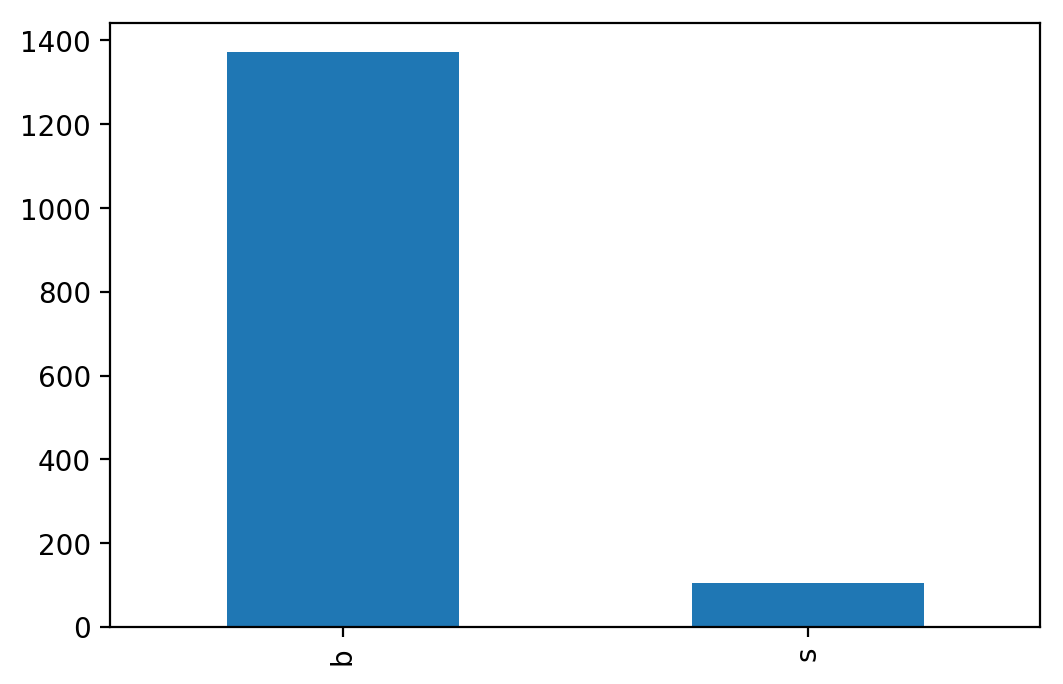

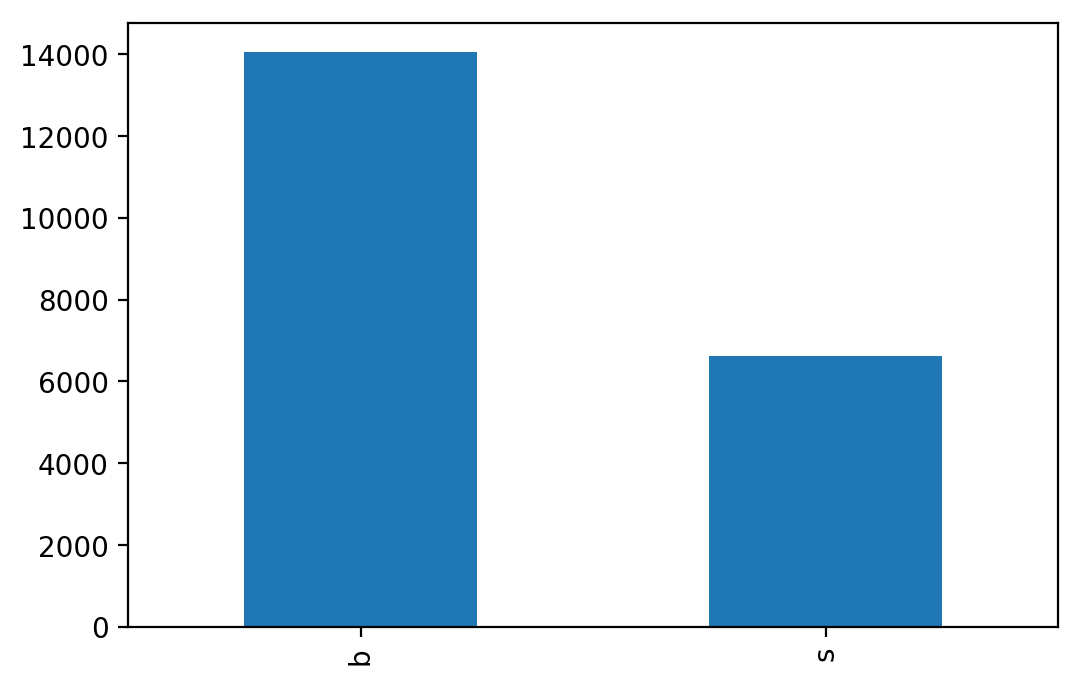

In [509]:
# Having a look at the proportion of b and s events when splitting into 8 bins:
l = creating_8_bins_missing_values(train_set)
for i in range(8):
    fig, ax = plt.subplots(1,1) ;
    l[i]['Label'].value_counts().plot(kind = 'bar') ;

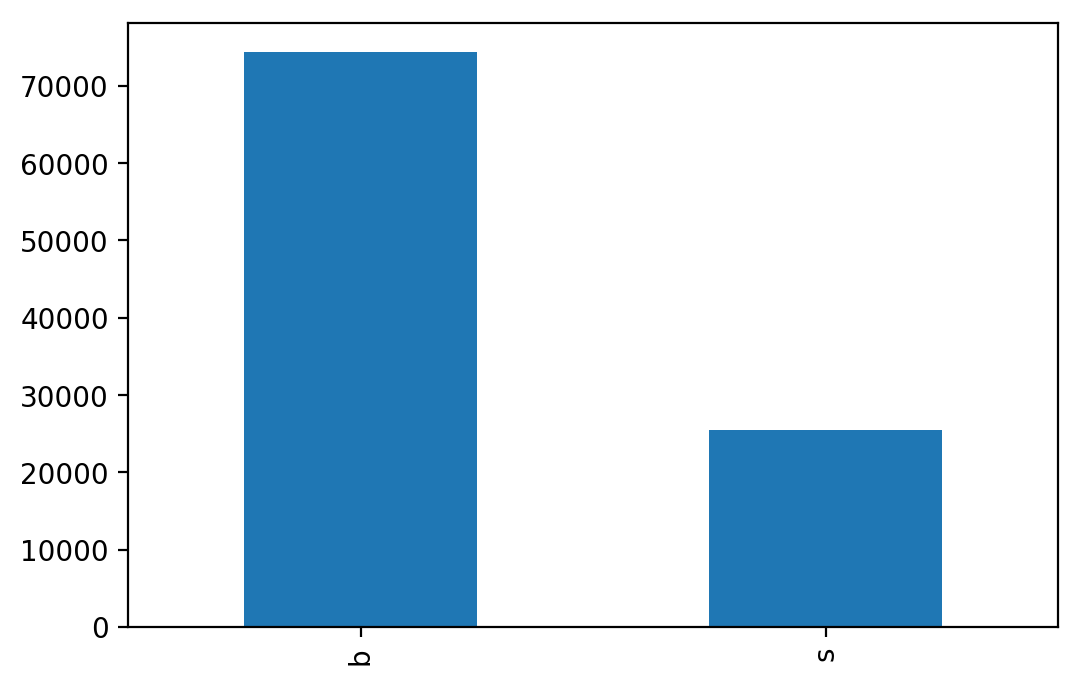

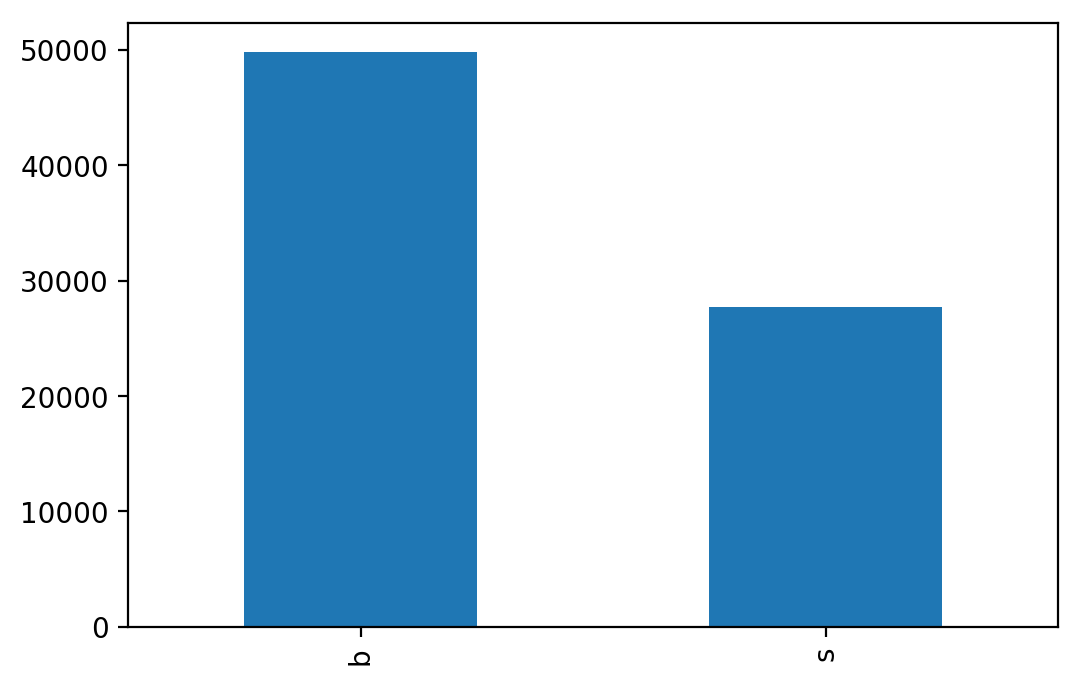

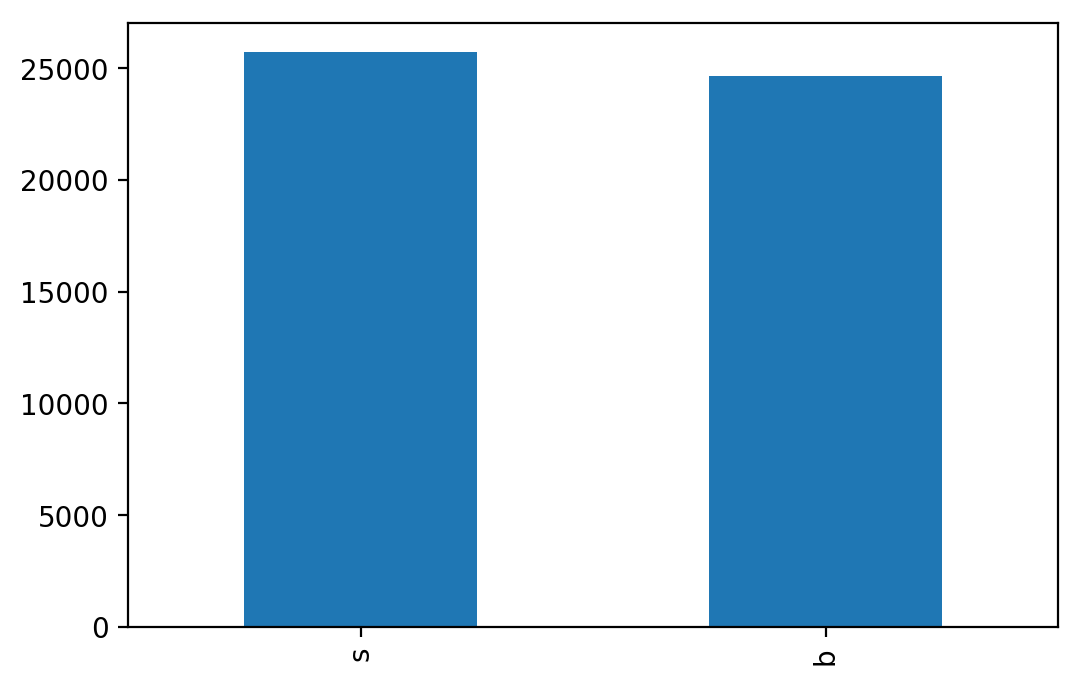

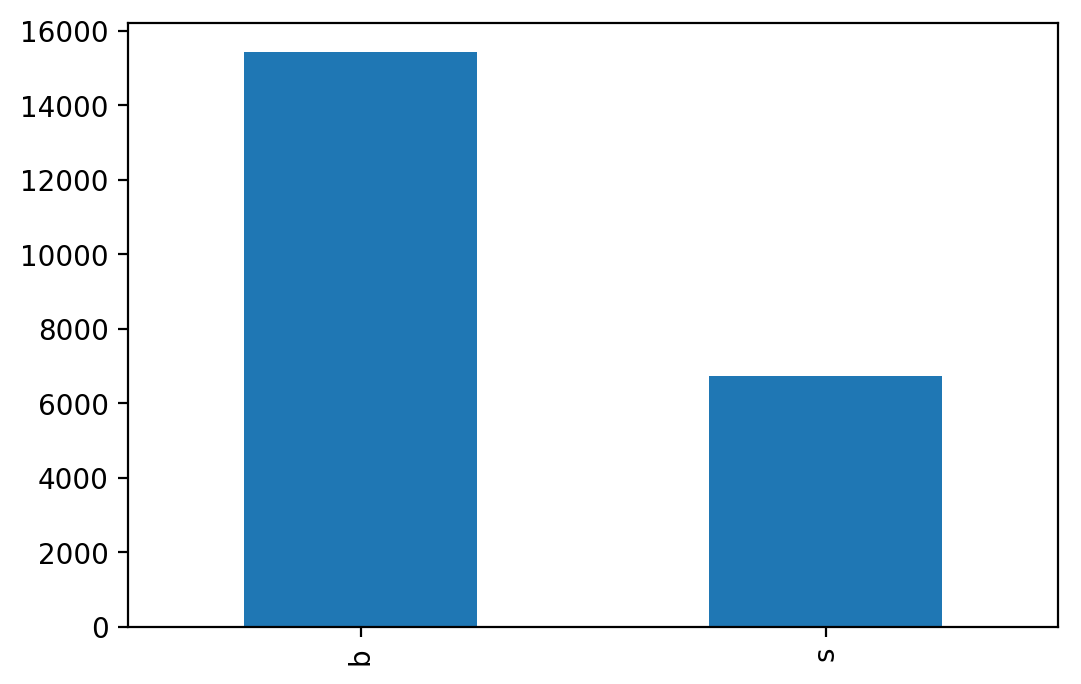

In [510]:
# Having a look at the proportion of b and s events when splitting into 4 bins:
l = creating_4_bins_missing_values(train_set)
for i in range(4):
    fig, ax = plt.subplots(1,1) ;
    l[i]['Label'].value_counts().plot(kind = 'bar');

## Feature engineering
From the histogram plots, one can notice that several features have a skewed distribution. Therefore, features with a positive support were log-transformed in order to provide our model with more balanced distributions.

In [7]:
def log_transform_feature(X):
    # columns with positive values
    columns_positive = list(X.columns[(X <= 0).sum() == 0])
    # removing certains columns though
    col_to_remove = ['Weight', 'DER_deltar_tau_lep', 'EventId']
    columns_positive = [e for e in columns_positive if e not in col_to_remove]
    #X[columns_positive] = np.log(X[columns_positive])
    Y = X 
    Y[columns_positive] = np.log(1/(1 + Y[columns_positive]))
    return Y

In [8]:
def removing_phi_variables(X):
    col_to_remove = ['PRI_jet_leading_phi', 'PRI_jet_subleading_phi', 'PRI_lep_phi', 'PRI_met_phi', 'PRI_tau_phi']
    col_to_remove_good = [e for e in col_to_remove if e in X.columns]
    X = X.drop(col_to_remove_good, axis=1)
    return X

# Models

## Logistic Regression
First, we are going to implement a logistic regression, which is one of the basic ML algorithms for classification.

In [9]:
def collecting_data(train_set,test_set):
    X = train_set.iloc[:,1:-2]
    Weights = train_set.iloc[:, -2]
    y = train_set.iloc[:, -1]
    X_test_kaggle = test_set.iloc[:,1:]
    return X, y, X_test_kaggle, Weights

In [10]:
# Preprocessing 1 method for our data
# replacing NaN by mean, log transforming some features
# Standard-scaling data, binary encoding for labels
def preprocessing1_data(X_train, X_test, y):
    X_train = replacing_nan_by_mean(X_train)
    X_test = replacing_nan_by_mean(X_test)
    X_train = log_transform_feature(X_train)
    X_test = log_transform_feature(X_test)
    X_train = removing_phi_variables(X_train)
    X_test = removing_phi_variables(X_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y = (y == 's').astype(int)
    return X_train, X_test, y

In [11]:
## Preprocessing with 4 bins
def preprocessing_with_bins(train_set, test_set):
    l_train = creating_4_bins_missing_values(train_set)
    l_test = creating_4_bins_missing_values(test_set)
    l_tr = []; l_y = []; l_te = []; l_w = [];
    for i in range(4):
        X, y, X_test_kaggle, Weights = collecting_data(l_train[i], l_test[i])
        X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
        l_tr.append(X)
        l_y.append(y)
        l_te.append(X_test_kaggle)
        l_w.append(Weights)
    return l_tr, l_y, l_te, l_w

### About class_weight
For how class_weight works: It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1. So higher class-weight means you want to put more emphasis in terms of penalization on a class. Therefore, we want to penalize class 'b' which is more frequent than class 's' in our training set. Doing so, our model will tend to pick class 's' more frequently, as class 'b' increases more our loss. Therefore, this is why we used the 'balanced' method for our classifier.

In [15]:
def unbalanced_class(X_train):
    X_b = X_train[X_train.Label == 'b']
    X_s = X_train[X_train.Label == 's']
    dico = {1:X_train.shape[0]/X_s.shape[0], 0:X_train.shape[0]/X_b.shape[0]}
    return dico

In [517]:
# Model with cross-validation for tuning the regularisation parameter C : NaN replaced by mean
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
scores = ['accuracy', 'precision', 'recall', 'roc_auc']
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
clf = LogisticRegression(penalty = 'l2', class_weight = 'balanced')
clf = LogisticRegression(penalty = 'l2')
clf_GridSearch = GridSearchCV(clf, tuned_parameters, scoring = scores, cv = 5, refit = 'precision')
clf_GridSearch.fit(X, y)
best_params_w_o_bins = clf_GridSearch.best_params_
results_w_o_bins = clf_GridSearch.cv_results_


In [518]:
# Model with cross-validation for tuning the regularisation parameter C : Model with 4 bins
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
score = ['accuracy', 'roc_auc', 'precision', 'recall']
l_tr, l_y, l_te, l_w = preprocessing_with_bins(train_set, test_set)
clf = LogisticRegression(penalty = 'l2', class_weight = 'balanced')
l_best_param_bins = []
l_cv_results_bins = []
for i in range(4):
    clf_GridSearch = GridSearchCV(clf, tuned_parameters, scoring = score, cv = 5, refit = 'precision')
    clf_GridSearch.fit(l_tr[i], l_y[i])
    l_best_param_bins.append(clf_GridSearch.best_params_)
    l_cv_results_bins.append(clf_GridSearch.cv_results_)

# Getting the average of the results on the 4 bins
tab_acc = np.zeros(len(tuned_parameters[0]['C']))
tab_pre = np.zeros(len(tuned_parameters[0]['C']))
tab_rec = np.zeros(len(tuned_parameters[0]['C']))
tab_roc = np.zeros(len(tuned_parameters[0]['C']))

for i in range(1,4):
    tab_acc = np.vstack((tab_acc, l_cv_results_bins[i]['mean_test_accuracy']))
    tab_acc = pd.DataFrame(data=tab_acc)
    tab_pre = np.vstack((tab_pre, l_cv_results_bins[i]['mean_test_precision']))
    tab_pre = pd.DataFrame(data=tab_pre)
    tab_rec = np.vstack((tab_rec, l_cv_results_bins[i]['mean_test_recall']))
    tab_rec = pd.DataFrame(data=tab_rec)
    tab_roc = np.vstack((tab_roc, l_cv_results_bins[i]['mean_test_roc_auc']))
    tab_roc = pd.DataFrame(data=tab_roc)
tab_acc = tab_acc[1:].mean()
tab_pre = tab_pre[1:].mean()
tab_rec = tab_rec[1:].mean()
tab_roc = tab_roc[1:].mean()

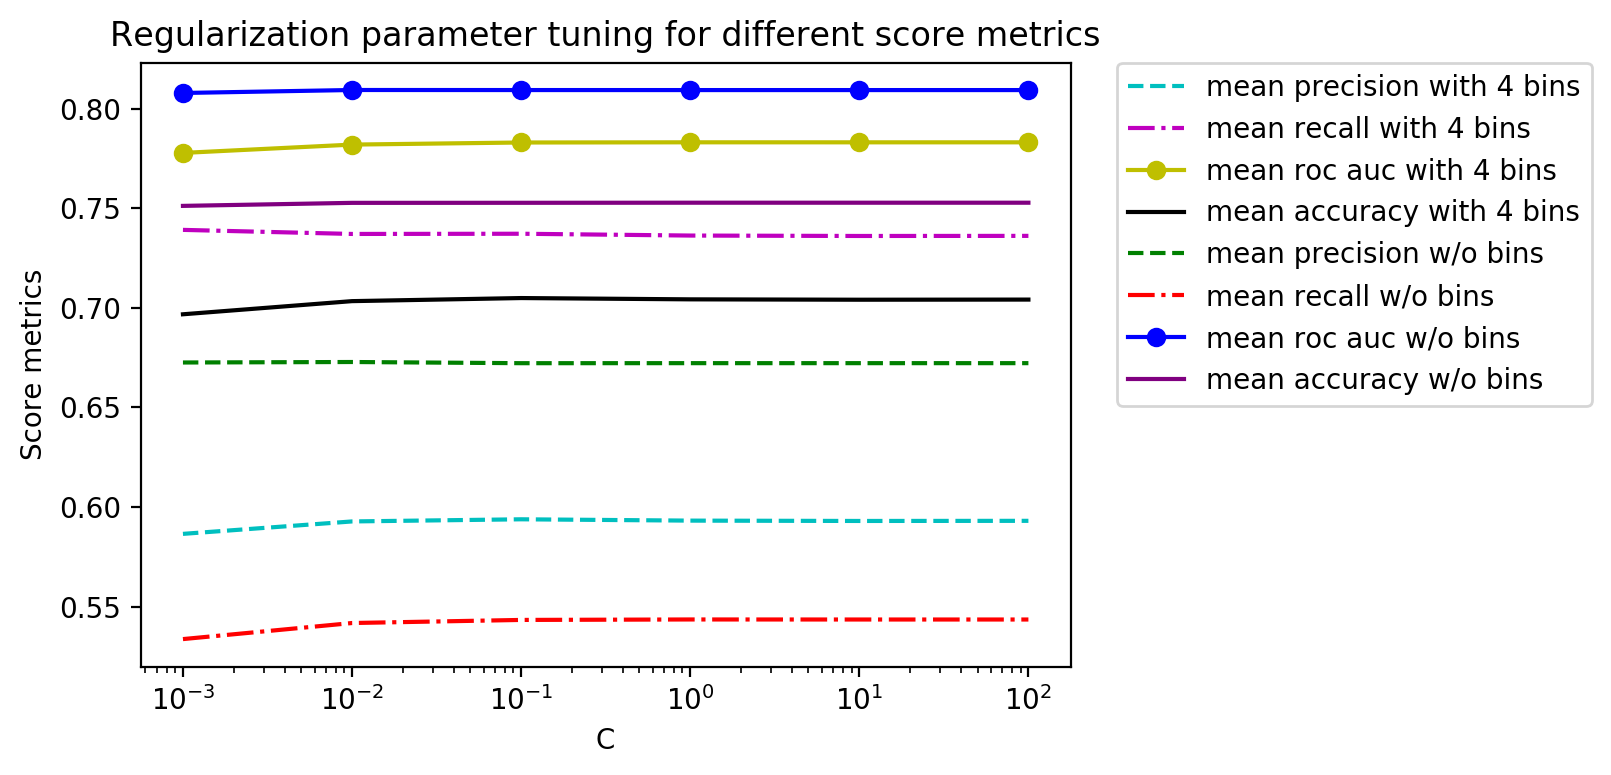

In [522]:
### Plotting the results
### Plotting the results obtained with 4 bins for our dataset
plt.semilogx(tuned_parameters[0]['C'], list(tab_pre), '--', 
             label = 'mean precision with 4 bins', color = 'c');
plt.semilogx(tuned_parameters[0]['C'], list(tab_rec), '-.', 
             label = 'mean recall with 4 bins', color = 'm' );
plt.semilogx(tuned_parameters[0]['C'], list(tab_roc), '-o',
             label = 'mean roc auc with 4 bins', color = 'y');
plt.semilogx(tuned_parameters[0]['C'], list(tab_acc), '-',
             label = 'mean accuracy with 4 bins', color = 'k');

### Plotting the results obtained without binning our dataset
plt.semilogx(tuned_parameters[0]['C'], list(results_w_o_bins['mean_test_precision']), '--', 
             label = 'mean precision w/o bins', color = 'g');
plt.semilogx(tuned_parameters[0]['C'], list(results_w_o_bins['mean_test_recall']), '-.', 
             label = 'mean recall w/o bins', color = 'r' );
plt.semilogx(tuned_parameters[0]['C'], list(results_w_o_bins['mean_test_roc_auc']), '-o',
             label = 'mean roc auc w/o bins', color = 'b');
plt.semilogx(tuned_parameters[0]['C'], list(results_w_o_bins['mean_test_accuracy']), '-',
             label = 'mean accuracy w/o bins', color = 'purple');

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xlabel('C');
plt.ylabel('Score metrics');
plt.title('Regularization parameter tuning for different score metrics');

In [523]:
# Best parameter for C (even though it does not seem to be very significant)
best_params_w_o_bins

{'C': 0.01}

### Conclusion of the model
Conclusion of the model : Not too bad for a start. We do see a quite good roc_auc and an acceptable recall and accuracy for our classifier. The precision is quite bad, even though we used the 'balanced' mode to penalize more the examples with label 1 in our loss. We are also able to come to the conclusion that the regularisation parameter has no influence on the results. This is a little bit surprising. Meaning that we do not have to mane parameters, as we do not seem to be overfitting to the train set. 
Definetely, between the approach with recoding the NaN with mean value and the approach with 4 bins to reduce drastically the amount of missing values, the first approach seems to give sligthly better results. 

As we have seen before, it looks like the regularisation parameter has no influence on the performance of our model. Still, our model is quite good in terms of ROC AUC. One of our idea is therefore to pick the treshold that gives us this best TP and FP rate and select this parameter for our final Logistic Regression model, while choosing the "best" parameter for regularisation which is for $C \approx 0.01$.  

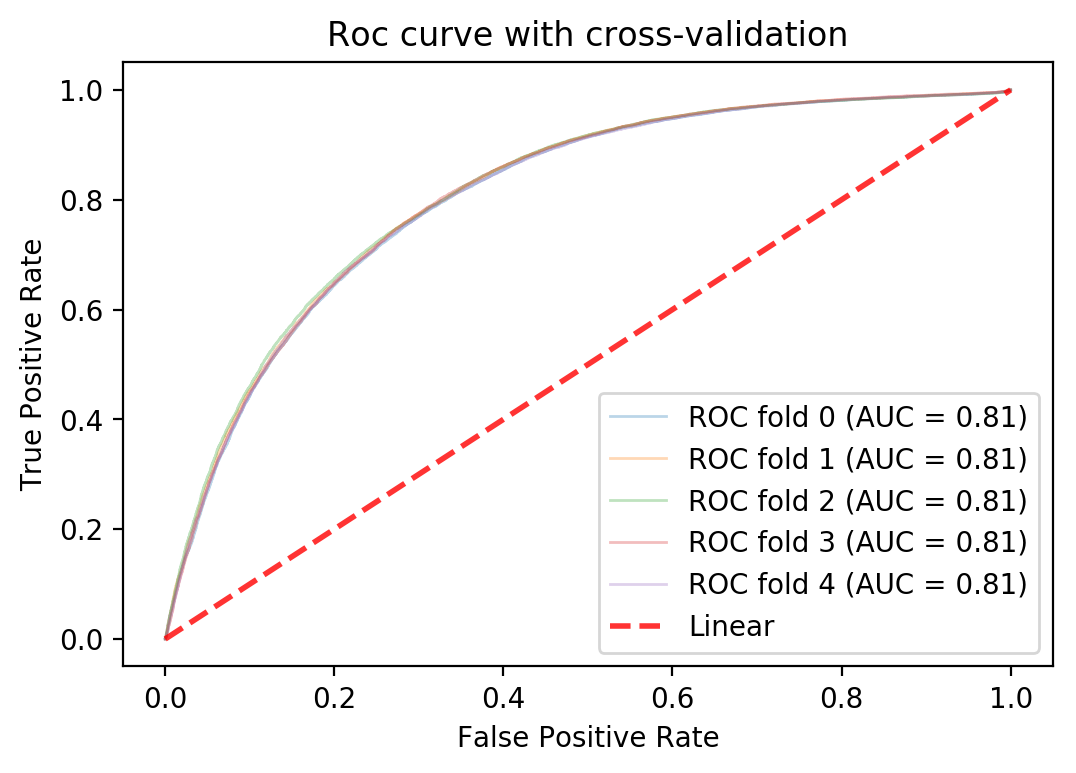

In [524]:
# Plotting the ROC AUC curve for this classifier.
# We pick the regularisation parameter that seems to be the best for us, based on our previous grid-search
# cross-validation.
C_range = [0.01]
skf = StratifiedKFold(n_splits = 5)
score = ['roc_auc']
l_fpr = [] ; l_tpr = [] ; l_tresholds = []
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
for c in C_range:
    i = 0
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(C = c, class_weight = 'balanced' )
        clf.fit(X_train, y_train)
        predicted_proba = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, predicted_proba)
        l_fpr.append(fpr)
        l_tpr.append(tpr)
        l_tresholds.append(thresholds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw = 1, alpha = 0.3, label = \
            'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1  
plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'r', \
        label = 'Linear', alpha = 0.8)
plt.legend(loc = "lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve with cross-validation')

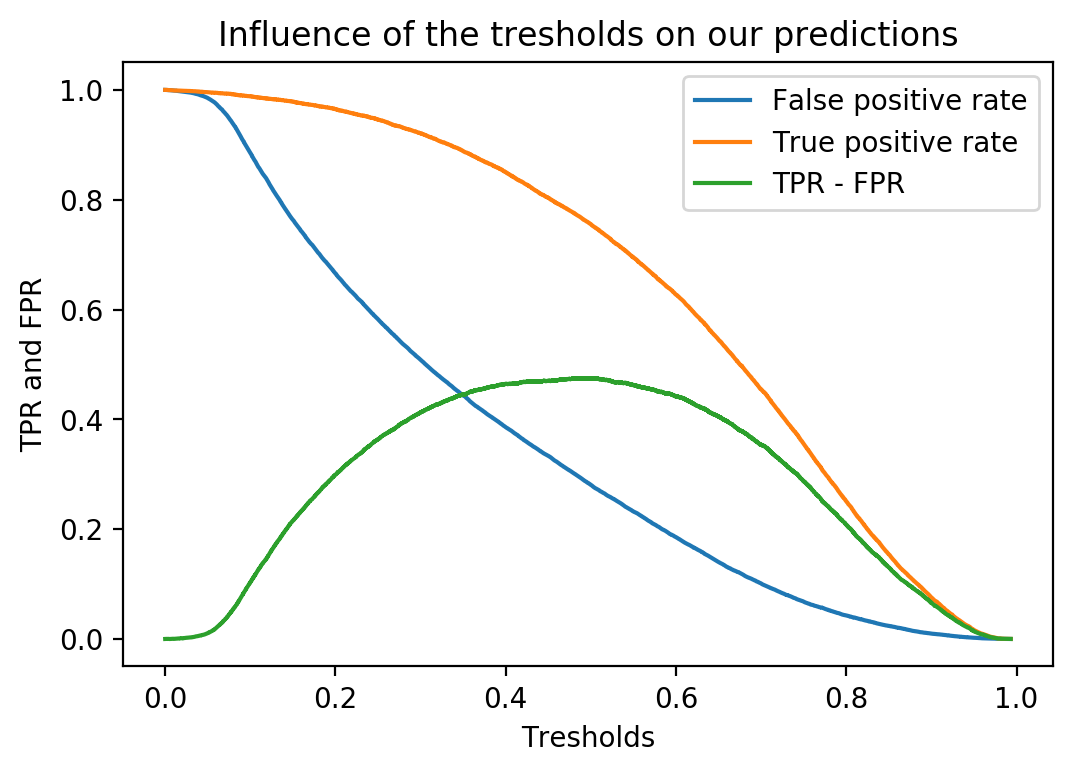

In [525]:
## Plotting the influence of the thresholds on the predictions
plt.plot(l_tresholds[1], l_fpr[1], label = 'False positive rate')
plt.plot(l_tresholds[1], l_tpr[1], label = 'True positive rate')
diff_tpr_fpr = l_tpr[1] - l_fpr[1]
plt.plot(l_tresholds[1], diff_tpr_fpr, label = 'TPR - FPR' )
plt.xlabel('Tresholds')
plt.ylabel('TPR and FPR')
plt.legend(loc = "upper right")
plt.title('Influence of the tresholds on our predictions')

In [526]:
# Function to find the optimal threshold
def finding_optimal_threshold(diff_tpr_fpr, l_tresholds, l_tpr, l_fpr):
    index = np.argmax(diff_tpr_fpr)
    opt_treshold = l_tresholds[1][index]
    maxi = max(diff_tpr_fpr)
    print('The optimal treshold found is: %f' % opt_treshold)
    TPR = l_tpr[1][index]
    FPR = l_fpr[1][index]
    precision = TPR / (TPR + FPR)
    recall = TPR
    accuracy = (TPR - FPR + 1) / 2 
    print('At this optimal treshold, the precision is : %f, the recall is: %f and the accuracy is : %f' % 
      (precision, recall, accuracy)) 

In [527]:
# Finding the optimal treshold for Logistic Regression
finding_optimal_threshold(diff_tpr_fpr, l_tresholds, l_tpr, l_fpr)

The optimal treshold found is: 0.496419
At this optimal treshold, the precision is : 0.727624, the recall is: 0.759309 and the accuracy is : 0.737536


From the previous plot, a good treshold seems to lie around 0.5. It might may be a good thing to take it around 0.6 to decrease the rate of false positive.

## Dimensionality Reduction
### PCA

In [23]:
# Fitting and transforming our data_set with PCA
def pca_dataset(train_set, test_set, n):
    X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
    X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
    pca = PCA(n_components = n)
    X_new = pca.fit_transform(X)
    X_test_new = pca.fit_transform(X_test_kaggle)
    return X_new, X_test_new, y, Weights

The variance ratio explained by the first 15 principal components is of 0.722348


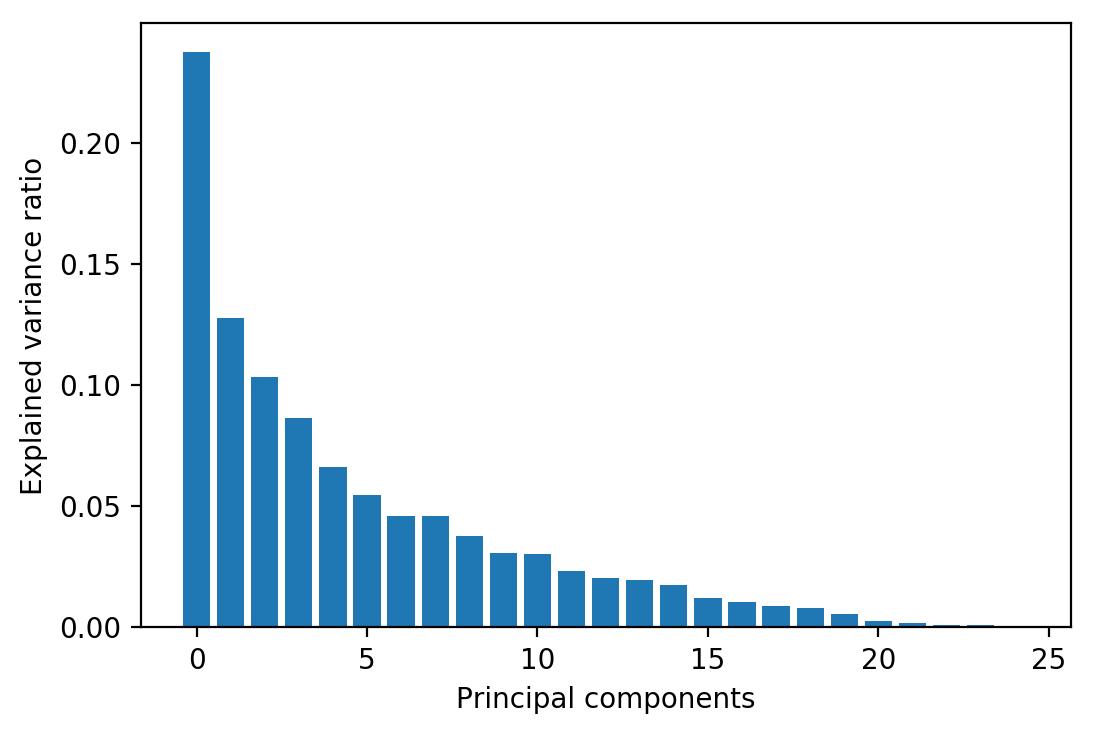

In [416]:
# Conducting the PCA. Note that, at that point, we already got rid off the pretty uniform PRI_..._phi features. 
pca = PCA()
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
pca.fit(X);
x = np.arange(len(pca.explained_variance_ratio_));
plt.bar(x, pca.explained_variance_ratio_, width = 0.8);
plt.xlabel("Principal components")
plt.ylabel("Explained variance ratio")
print('The variance ratio explained by the first 15 principal components is of %f'% 
      pca.explained_variance_ratio_[1:16].sum())

It seems reasonable to keep the first 15 principal components to reduce the dimension of our model. These 15 variables explains already 75% of the variance of the data, which is quite good.

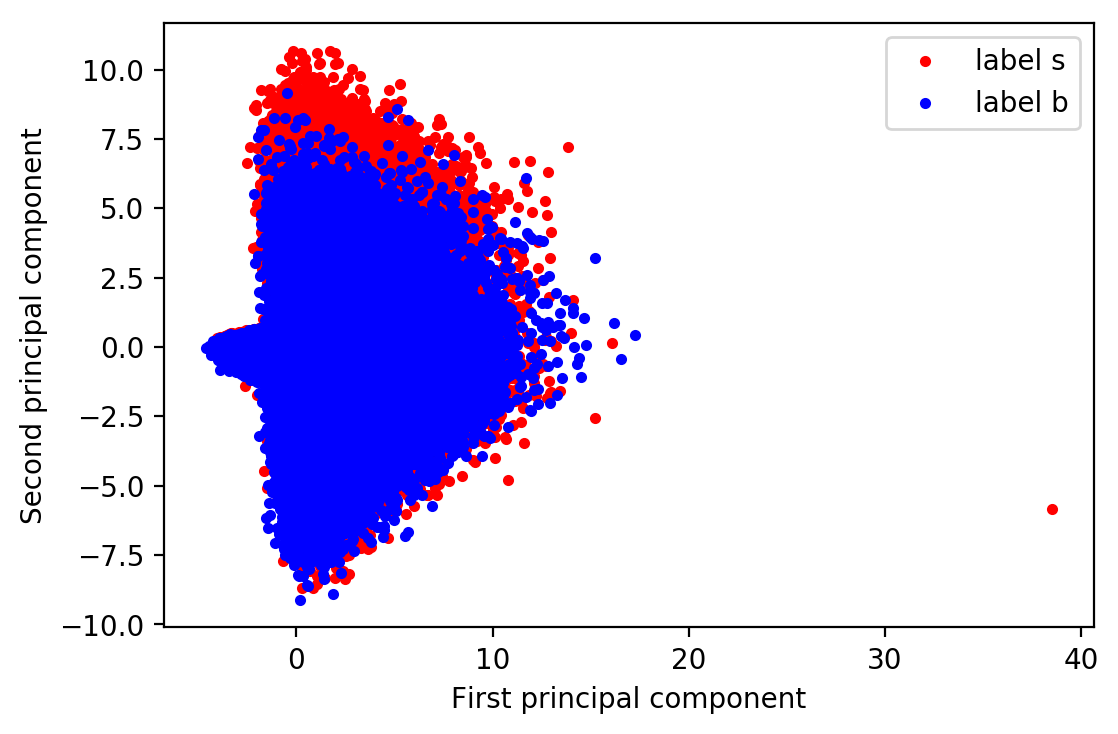

In [475]:
## First and second composant representation in the plane from the PCA
X_pca, X_test_pca, y_pca, Weights_pca = pca_dataset(train_set, test_set, 15)
# Transforming it to a dataframe
X_pca = pd.DataFrame(data = X_pca)
# Adding the label column to our dataframe for convenience
X_pca['label'] = y_pca
X_0 = X_pca.loc[X_pca['label'] == 1, 0]
Y_0 = X_pca.loc[X_pca['label'] == 1, 1]
X_1 = X_pca.loc[X_pca['label'] == 0, 0]
Y_1 = X_pca.loc[X_pca['label'] == 0, 1]
plt.plot(X_0, Y_0, '.', color = 'r', label = 'label s')
plt.plot(X_1, Y_1, '.', color = 'b', label = 'label b')
plt.legend()
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

## K-Neirest-Neighbors (TIME-CONSUMING : DO NOT RUN)
This section is taking a lot of time to run. So we advise not to run it and just to check the results in the report.

In [30]:
tuned_parameters = [{'n_neighbors' : [5, 10, 15, 20]}]
scores = ['accuracy', 'precision', 'recall', 'roc_auc']
X, X_test, y, Weights = pca_dataset(train_set, test_set, 7)
# We are going to test the knn classifier on a small dataset with only 10000 examples
sss = StratifiedShuffleSplit(n_splits=25)
# Now we just want to get the indices for our first split (this split is keeping the propotion of classes as in the 
# train_set).
i = 1
for train_index, test_index in sss.split(X, y):
    if i == 1:
        tr_index, te_index = train_index, test_index
    i += 1
clf = KNeighborsClassifier(weights = 'uniform')
clf_GridSearch = GridSearchCV(clf, tuned_parameters, scoring = scores, cv = 5, refit = 'precision')
clf_GridSearch.fit(X[tr_index], y[tr_index])
best_params_knn = clf_GridSearch.best_params_
results_knn = clf_GridSearch.cv_results_

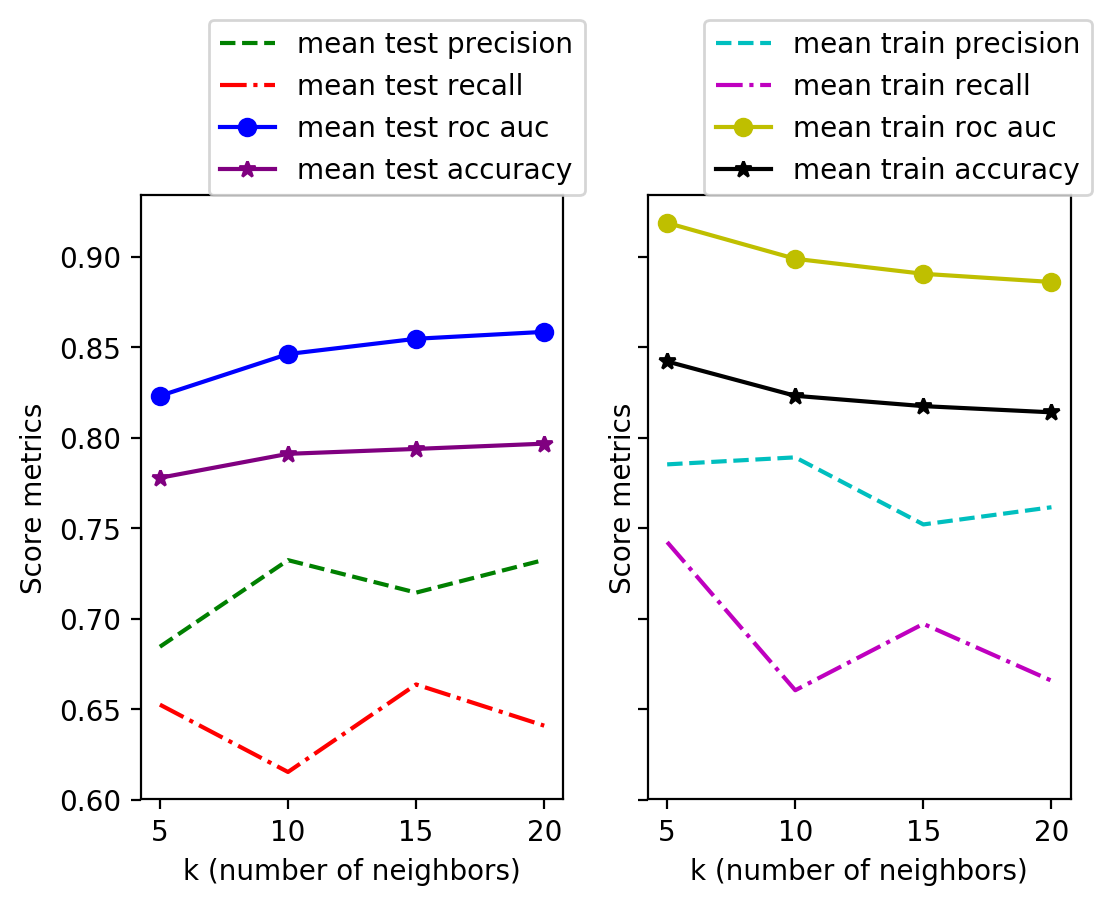

In [60]:
### Plotting the results of the cross-validation 
# For the test set

f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_test_precision']), '--', 
             label = 'mean test precision', color = 'g');
ax1.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_test_recall']), '-.', 
             label = 'mean test recall', color = 'r' );
ax1.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_test_roc_auc']), '-o',
             label = 'mean test roc auc', color = 'b');
ax1.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_test_accuracy']), '-*',
             label = 'mean test accuracy', color = 'purple');
ax1.legend(bbox_to_anchor=(1.05, 1), loc=4, borderaxespad=0.);
ax1.set_xlabel('k (number of neighbors)');
ax1.set_ylabel('Score metrics');

# For the train set
ax2.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_train_precision']), '--', 
             label = 'mean train precision', color = 'c');
ax2.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_train_recall']), '-.', 
             label = 'mean train recall', color = 'm' );
ax2.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_train_roc_auc']), '-o',
             label = 'mean train roc auc', color = 'y');
ax2.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_train_accuracy']), '-*',
             label = 'mean train accuracy', color = 'k');

ax2.legend(bbox_to_anchor=(1.05, 1), loc=4, borderaxespad=0.);
ax2.set_xlabel('k (number of neighbors)');
ax2.set_ylabel('Score metrics');

In [56]:
best_params_knn 

{'n_neighbors': 20}

The knn method seems quite good, especially as it is here working on a small subset of our dataset (even though the proportion of labels in the train set was preserved). Only 10000 samples were used for training here and only the first 7 principal components were considered (53% of variance only explained...) , whereas the total training set has 250000 examples. The main issue of the knn method is that it is very slow to converge. I think it would perform quite well if we use the total data set, and let say 15 variables ( explaining 73% of the variance), but this is very likely to be completed in at least 5 hours. Hence, this type of model is not realistic. 

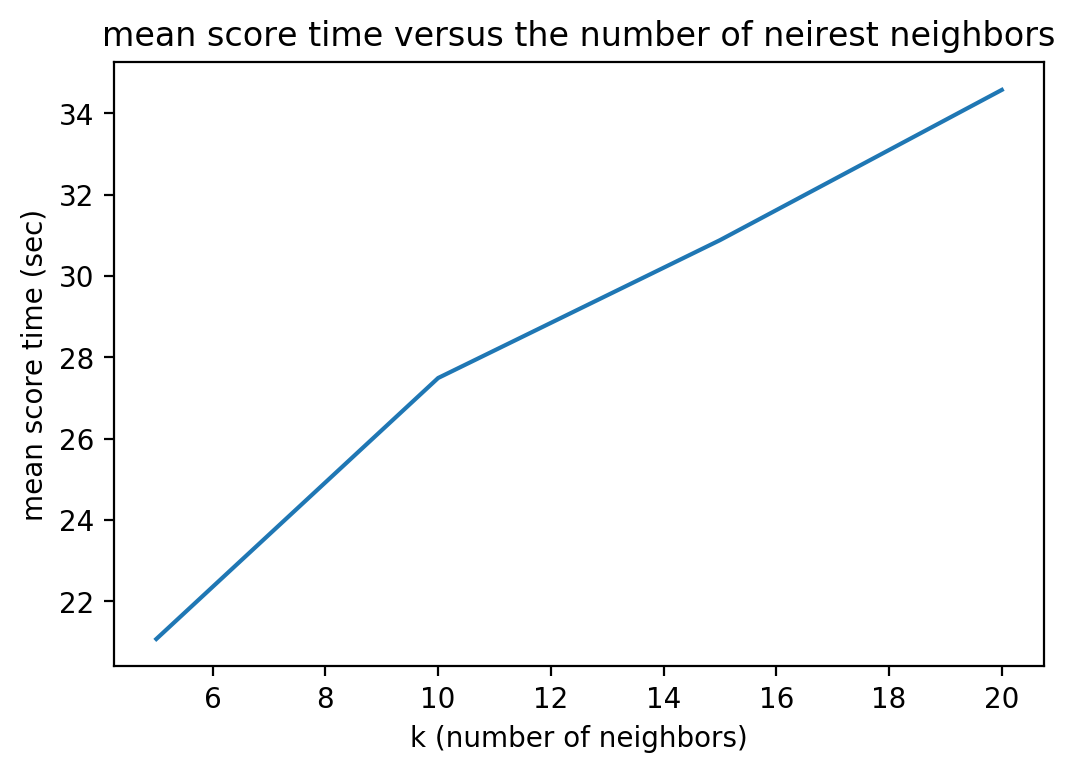

In [64]:
plt.plot(tuned_parameters[0]['n_neighbors'], list(results_knn['mean_score_time']) );
plt.xlabel('k (number of neighbors)');
plt.ylabel('mean score time (sec)');
plt.title('mean score time versus the number of neirest neighbors');

## Random Forest (TIME CONSUMING : DO NOT RUN)
This cross-validation is particularly time-consuming, so we would advise not to run the following cell and rather refer to the report for detailed results.

In [160]:
tuned_parameters = {'n_estimators': [150], 'max_depth': [5, 7, 9, 12], 'min_samples_leaf':[5, 50, 100, 200]}
scores = ['accuracy', 'precision', 'recall', 'roc_auc']
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
# The feature scaling is not really necessary with RF, but it is not harmful. 
# The missing values are replaced by the mean. Indeed RF cannot exactly work with NaN, as opposed to GBDT.
X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
clf = RandomForestClassifier(class_weight = 'balanced')
clf_GridSearch = GridSearchCV(clf, tuned_parameters, scoring = scores, cv = 5, refit = 'precision')
clf_GridSearch.fit(X, y)
best_params_rf = clf_GridSearch.best_params_
results_rf = clf_GridSearch.cv_results_

In [162]:
best_params_rf

{'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 150}

In [189]:
## Function to help plotting the results of our cross-validation for the random forest algorithm.
def double_parameter_cross_validation(tuned_parameters, parameter_1, parameter_2):
    l = []
    for i in tuned_parameters[parameter_1]:
        for j in tuned_parameters[parameter_2]:
            l.append(str((i,j)))
    return l

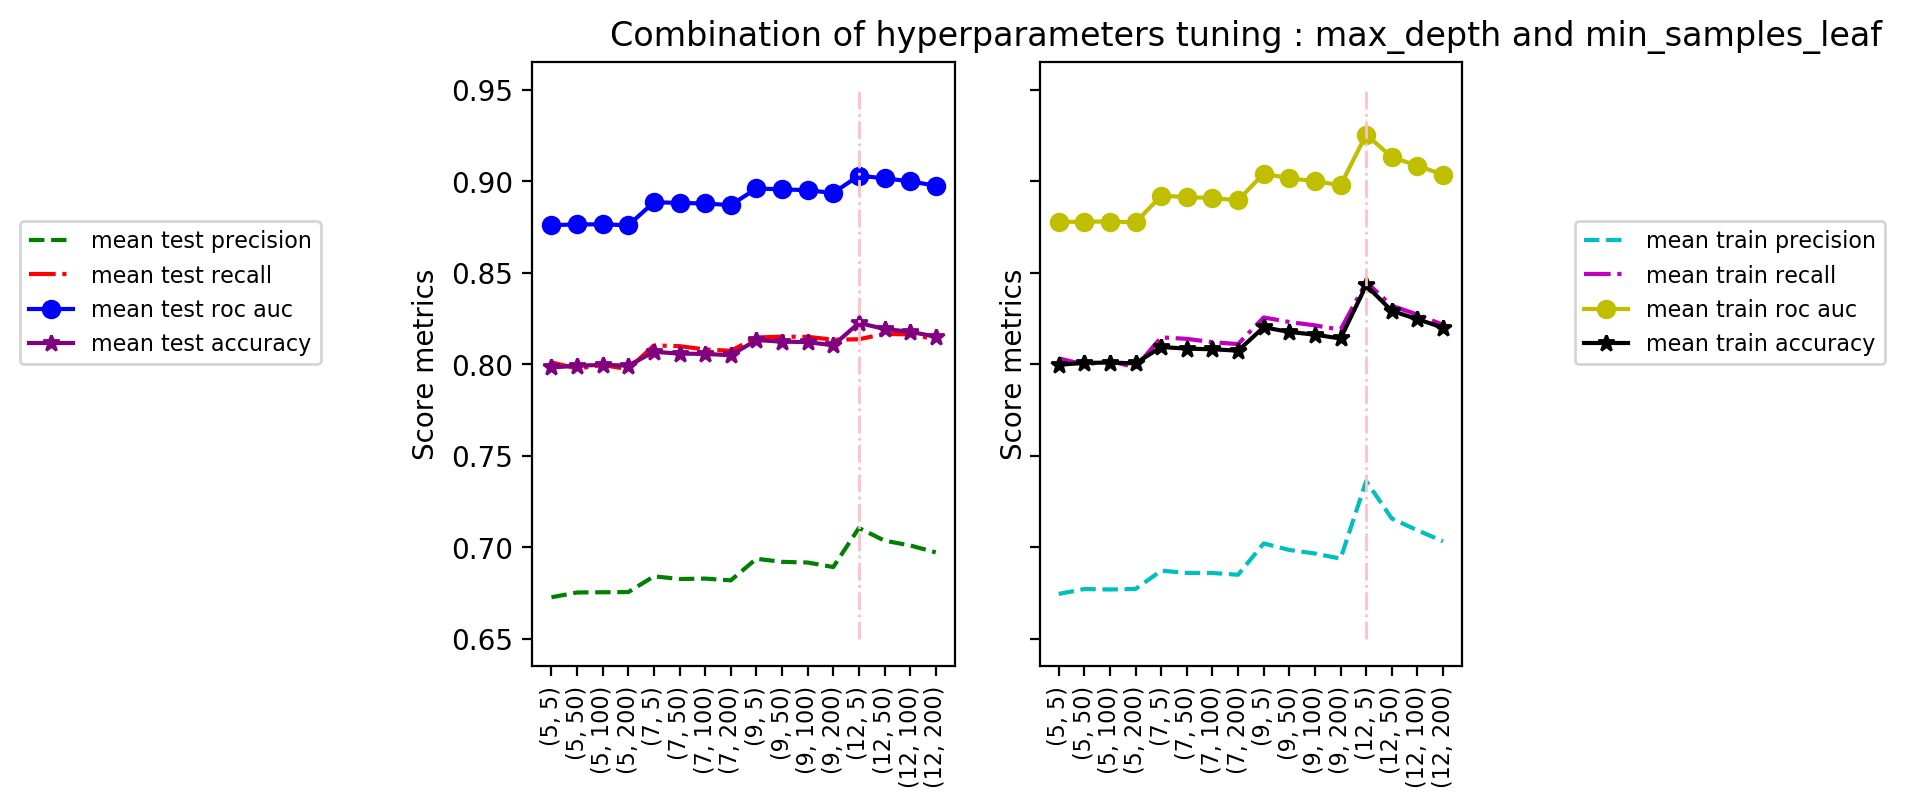

In [251]:
### Plotting the results of the cross-validation 
# For the test set


f, (ax1, ax2) = plt.subplots(1,2, sharey=True)
x = range(len(results_rf['params']))
ax1.plot(x, list(results_rf['mean_test_precision']), '--', 
             label = 'mean test precision', color = 'g');
ax1.plot(x, list(results_rf['mean_test_recall']), '-.', 
             label = 'mean test recall', color = 'r' );
ax1.plot(x, list(results_rf['mean_test_roc_auc']), '-o',
             label = 'mean test roc auc', color = 'b');
ax1.plot(x, list(results_rf['mean_test_accuracy']), '-*',
             label = 'mean test accuracy', color = 'purple');
y_13 = np.arange(0.65,1,0.05)
x_13 = np.repeat(12,len(y_13) )

ax1.plot(x_13, y_13, '-.',  color = 'pink', lw = 1.0)
ax1.legend(bbox_to_anchor=(-0.5, 0.5), loc=4, borderaxespad=0., fontsize = 8);
ax1.set_ylabel('Score metrics');
plt.title('Combination of hyperparameters tuning : max_depth and min_samples_leaf ')

# Setting the labels for the x-axis (gridsearch combination)
x_ticks_labels = double_parameter_cross_validation(tuned_parameters, 'max_depth', 'min_samples_leaf')
# Set number of ticks for x-axis
ax1.set_xticks(x);
# Set ticks labels for x-axis
ax1.set_xticklabels(x_ticks_labels, rotation=90, fontsize=8);

# For the train set
ax2.plot(x, list(results_rf['mean_train_precision']), '--', 
             label = 'mean train precision', color = 'c');
ax2.plot(x, list(results_rf['mean_train_recall']), '-.', 
             label = 'mean train recall', color = 'm' );
ax2.plot(x, list(results_rf['mean_train_roc_auc']), '-o',
             label = 'mean train roc auc', color = 'y');
ax2.plot(x, list(results_rf['mean_train_accuracy']), '-*',
             label = 'mean train accuracy', color = 'k');
ax2.plot(x_13, y_13, '-.',  color = 'pink', lw = 1.0)
ax2.legend(bbox_to_anchor=(2, 0.5), loc=4, borderaxespad=0., fontsize = 8);
x_ticks_labels = double_parameter_cross_validation(tuned_parameters, 'max_depth', 'min_samples_leaf')
# Set number of ticks for x-axis
ax2.set_xticks(x);
# Set ticks labels for x-axis
ax2.set_xticklabels(x_ticks_labels, rotation=90, fontsize=8);
ax2.set_ylabel('Score metrics');


In [253]:
tuned_parameters = {'n_estimators': [20], 'max_depth': [5, 7, 9, 12], 'min_samples_leaf':[5, 50]}
scores = ['accuracy', 'precision', 'recall', 'roc_auc']
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
# The feature scaling is not really necessary with RF, but it is not harmful. 
# The missing values are replaced by the mean. Indeed RF cannot exactly work with NaN, as opposed to GBDT.
clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1)
clf_GridSearch = GridSearchCV(clf, tuned_parameters, scoring = scores, cv = 5, refit = 'precision')
clf_GridSearch.fit(X, y)
best_params_rf = clf_GridSearch.best_params_
results_rf = clf_GridSearch.cv_results_

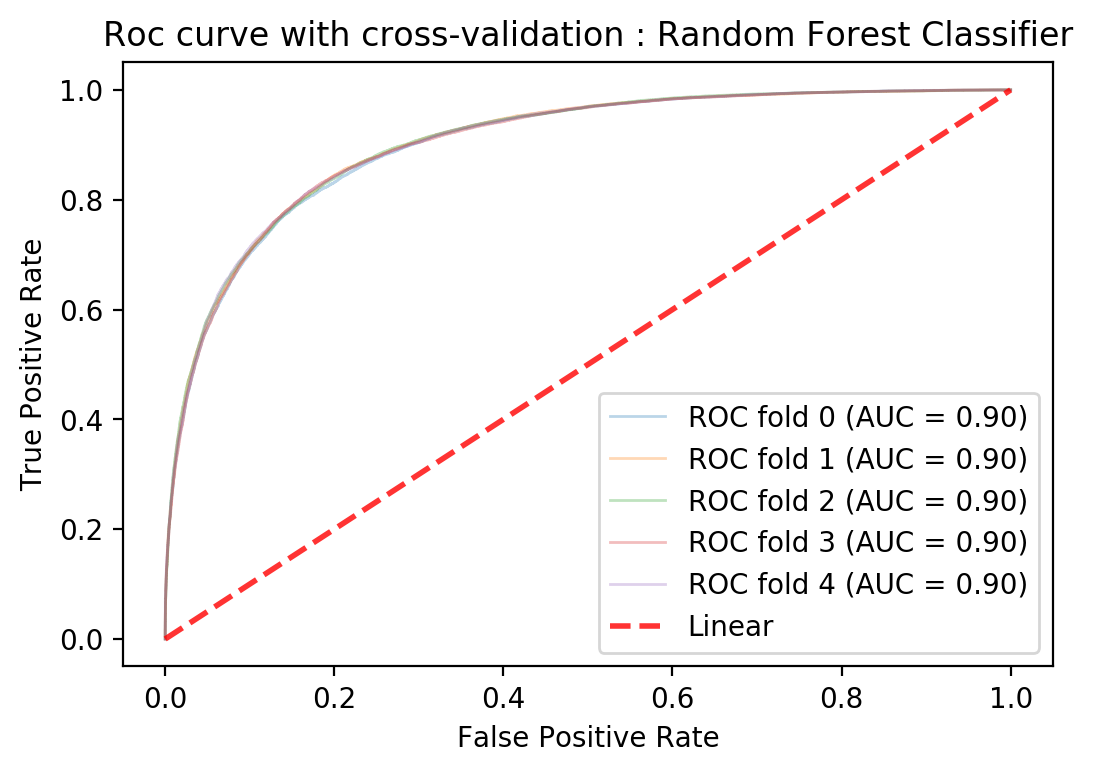

In [488]:
# Plotting the ROC AUC curve for this classifier.
# We pick the parameters that seemed to be the best for us, based on our previous grid-search
# cross-validation : n_estimators = 150, max_depth = 12, and min_samples_leaf = 5
skf = StratifiedKFold(n_splits = 5)
score = ['roc_auc']
l_fpr_rf = [] ; l_tpr_rf = [] ; l_tresholds_rf = []
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
i = 0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators = 150, max_depth = 12, min_samples_leaf = 5,
                        n_jobs = -1, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    predicted_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, predicted_proba)
    l_fpr_rf.append(fpr)
    l_tpr_rf.append(tpr)
    l_tresholds_rf.append(thresholds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw = 1, alpha = 0.3, label = \
        'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1  
plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'r', \
        label = 'Linear', alpha = 0.8)
plt.legend(loc = "lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve with cross-validation : Random Forest Classifier')

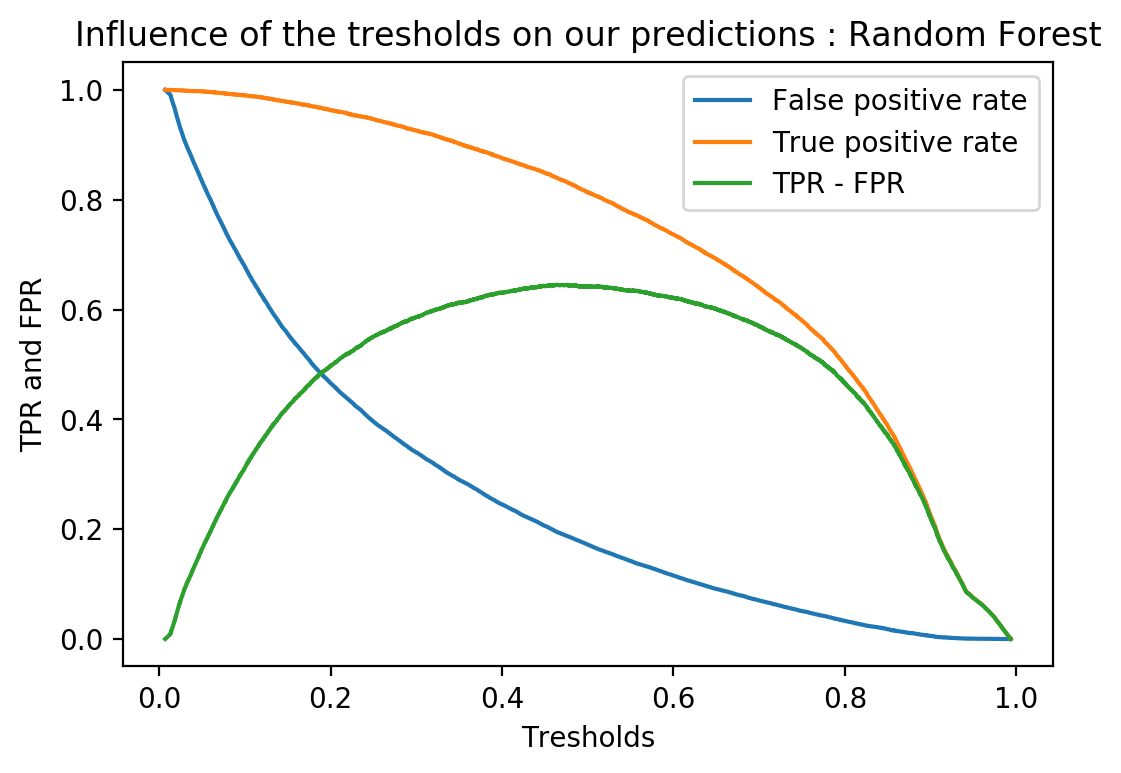

In [265]:
## Plotting the influence of the thresholds on the predictions
plt.plot(l_tresholds_rf[1], l_fpr_rf[1], label = 'False positive rate')
plt.plot(l_tresholds_rf[1], l_tpr_rf[1], label = 'True positive rate')
diff_tpr_fpr_rf = l_tpr_rf[1] - l_fpr_rf[1]
plt.plot(l_tresholds_rf[1], diff_tpr_fpr_rf, label = 'TPR - FPR' )
plt.xlabel('Tresholds')
plt.ylabel('TPR and FPR')
plt.legend(loc = "upper right")
plt.title('Influence of the tresholds on our predictions : Random Forest')

In [264]:
# Finding the optimal treshold for Random Forest
finding_optimal_threshold(diff_tpr_fpr_rf, l_tresholds_rf, l_tpr_rf, l_fpr_rf)

The optimal treshold found is: 0.475680
At this optimal treshold, the precision is : 0.816190, the recall is: 0.832497 and the accuracy is : 0.822507


The shape of the False positive rate and True positive rate with the threshold is better than for the Logistic Regression as one can notice that the False positive rate is more widely decreasing with the threshold than it used to. This model is clearly better, as it provides us with an AUC of around 0.90 which is clearly an improvement compared to the 0.81 score that was obtained with a Logistic regression.

## Neural Network

First, we need to define some additional metrics (precision, recall, f1-score) which are not implemented in keras and are very helpful to evaluate the performances of our model. 

In [32]:
### These two functions were imported from : 
##https://github.com/keras-team/keras/blob/53e541f7bf55de036f4f5641bd2947b96dd8c4c3/keras/metrics.py
# Function to define the precision metrics of a classifier
def keras_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Function to define the recall metrics of a classifier
def keras_recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [33]:
import keras

# Creating a first model of neural network : without cross-validation to evaluate performance
metrics = ['accuracy', keras_precision, keras_recall]
class_weight = unbalanced_class(train_set)
cvscores = {'acc': [], 'keras_precision': [], 'keras_recall':[]}
kfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=42)
X, y, X_test_kaggle, Weights = collecting_data(train_set, test_set)
X, X_test_kaggle, y = preprocessing1_data(X, X_test_kaggle, y)
for train, test in kfold.split(X,y):
    model = Sequential()
    model.add(Dense(50, activation = 'relu', input_shape = (25,)))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer= 'rmsprop',
              loss='binary_crossentropy',
              metrics = metrics)
    hist = model.fit(X[train], y[train], epochs=20, batch_size=50, class_weight = class_weight )
    scores = model.evaluate(X[test], y[test], verbose=0)
    for i in range(1,4):
        print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))
        cvscores[str(model.metrics_names[i])].append(scores[i])

Epoch 1/20
166666/166666 [==============================] - 5s 30us/step - loss: 0.8800 - acc: 0.7941 - keras_precision: 0.6629 - keras_recall: 0.8095
Epoch 2/20
166666/166666 [==============================] - 5s 29us/step - loss: 0.8237 - acc: 0.8100 - keras_precision: 0.6840 - keras_recall: 0.8298
Epoch 3/20
166666/166666 [==============================] - 5s 28us/step - loss: 0.8118 - acc: 0.8132 - keras_precision: 0.6889 - keras_recall: 0.8313
Epoch 4/20
166666/166666 [==============================] - 4s 26us/step - loss: 0.8034 - acc: 0.8155 - keras_precision: 0.6920 - keras_recall: 0.8324
Epoch 5/20
166666/166666 [==============================] - 4s 26us/step - loss: 0.7973 - acc: 0.8179 - keras_precision: 0.6964 - keras_recall: 0.8313 3s - loss: 0.8 - ETA: 1s - l
Epoch 6/20
166666/166666 [==============================] - 4s 26us/step - loss: 0.7931 - acc: 0.8200 - keras_precision: 0.6998 - keras_recall: 0.8306
Epoch 7/20
166666/166666 [==============================] - 4s 24

166668/166668 [==============================] - 4s 26us/step - loss: 0.7788 - acc: 0.8227 - keras_precision: 0.7044 - keras_recall: 0.8327
Epoch 11/20
166668/166668 [==============================] - 4s 26us/step - loss: 0.7768 - acc: 0.8242 - keras_precision: 0.7064 - keras_recall: 0.8348
Epoch 12/20
166668/166668 [==============================] - 4s 24us/step - loss: 0.7764 - acc: 0.8244 - keras_precision: 0.7069 - keras_recall: 0.8348
Epoch 13/20
166668/166668 [==============================] - 5s 27us/step - loss: 0.7755 - acc: 0.8246 - keras_precision: 0.7074 - keras_recall: 0.8330
Epoch 14/20
166668/166668 [==============================] - 4s 26us/step - loss: 0.7748 - acc: 0.8244 - keras_precision: 0.7073 - keras_recall: 0.8325
Epoch 15/20
166668/166668 [==============================] - 5s 33us/step - loss: 0.7745 - acc: 0.8254 - keras_precision: 0.7080 - keras_recall: 0.8344 0s - loss: 0.7754 - acc: 0.8250 - keras_precision: 0.7
Epoch 16/20
166668/166668 [==================

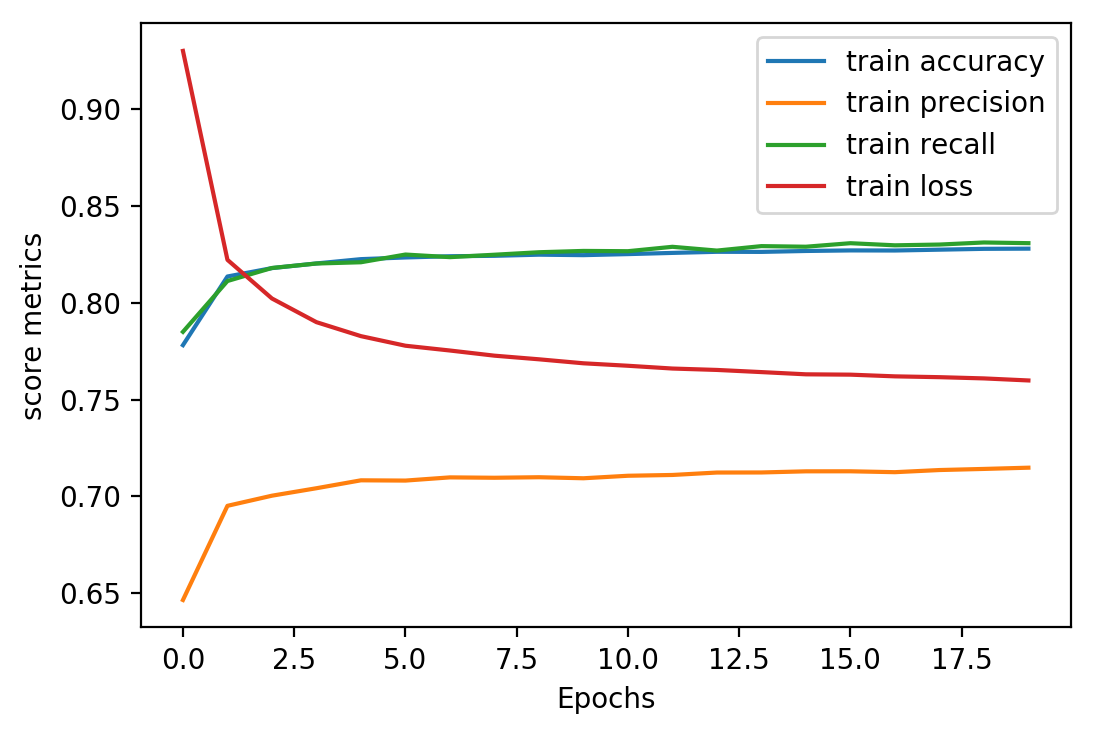

In [491]:
### Plotting the training phase results of the neural network 
xx = np.arange(len(hist.history['loss']))
plt.plot(xx, hist.history['acc'], label = 'train accuracy')
plt.plot(xx, hist.history['keras_precision'], label = 'train precision')
plt.plot(xx, hist.history['keras_recall'], label = 'train recall')
plt.plot(xx, hist.history['loss'], label = 'train loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('score metrics')

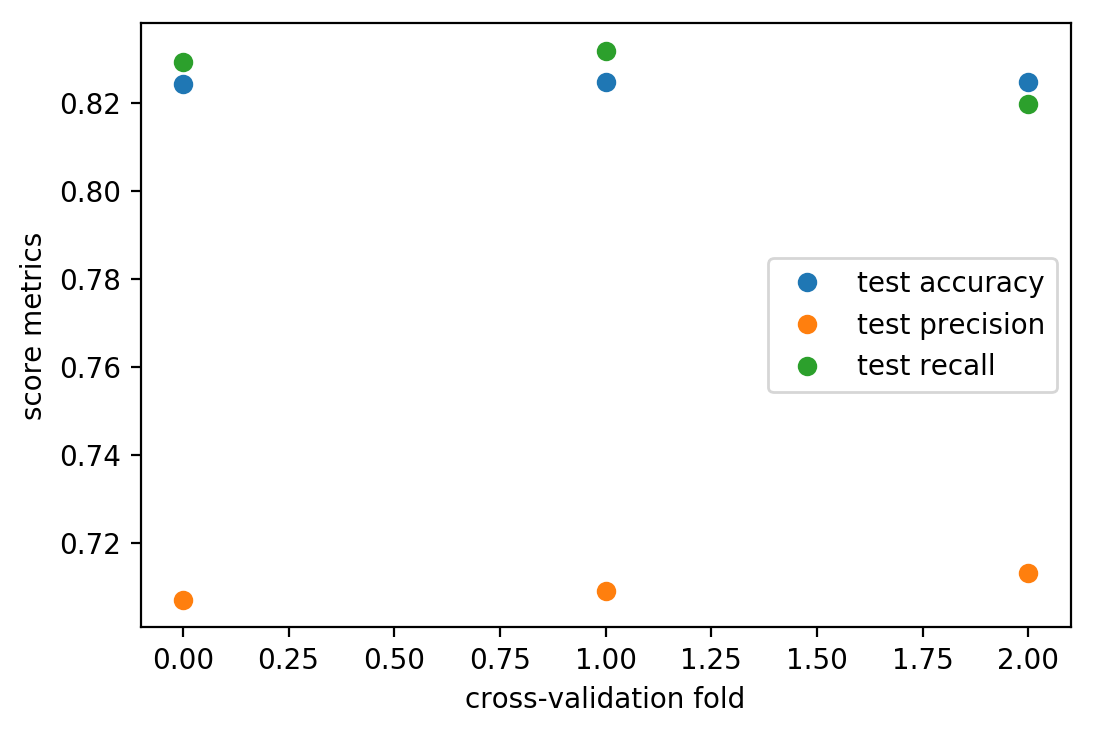

In [495]:
### Plotting the test phase results of the neural network.
xx = range(len(cvscores['acc']))
plt.plot(xx, cvscores['acc'], 'o',  label = 'test accuracy')
plt.plot(xx, cvscores['keras_precision'], 'o',  label = 'test precision')
plt.plot(xx, cvscores['keras_recall'], 'o',  label = 'test recall')
plt.xlabel('cross-validation fold')
plt.legend()
plt.ylabel('score metrics')